# International Workshop on Spectroscopy and Chemometrics 2022
# Data Challenge Solution - Tabular Models

# Data Description

Notes and Objective:
The dataset has been divided (by the organizers) into two Excel sheets
- Training dataset: contains the value to predict (cow diet) and the spectra
- Test dataset: contains only the spectra
The test dataset contains 1,089 spectra.

**The aim of the analysis is to predict the cow diet for the samples in the test dataset.**

**Sample collection**
Data used in this study originated from Teagasc Moorepark Dairy Research Farm (Fermoy, Co. Cork, Ireland) between May and August in 2015, 2016, and 2017. A total of 120 Holstein- Friesian cows from different parities were involved in the experiment across the years, with a mean number of 36 samples per cow, and with some of the cows participating in the experiment in more than 1 yr. Each year, 54 cows were randomly assigned to different dietary treatments for the entire lactation period. 

The treatment diets included grass (GRS), which consisted of cows maintained outdoors on a perennial ryegrass sward only, clover (CLV), where cows were maintained outdoors on a perennial ryegrass white clover sward (with an annual average clover content of 20%) only, and TMR, where cows were maintained indoors and fed with a single nutritional mix containing grass silage, maize silage, and concentrates. Further information on the experimental design and dietary treatments have been described by O’Callaghan et al. (2016). The cows were milked twice daily (0730 and 1530 h), and a.m. and p.m. milk samples were collected once weekly from consecutive milkings and analysed by a Pro-Foss FT6000 (FOSS). A total of 4,364 milk spectra were stored, comprising 1,060 wavelengths in the region from 925 cm−1 and 5,010 cm−1. The wavelengths values were recorded as transmittance values.

O’Callaghan, T. F., D. Hennessy, S. McAuliffe, K. N. Kilcawley, M. O’Donovan, P. Dillon, R. P. Ross, and C. Stanton. 2016. Effect of pasture versus indoor feeding systems on raw milk composition and quality over an entire lactation. J. Dairy Sci. 99:9424–9440. https://doi.org/10.3168/jds.2016-10985.


# Run tabular experiments:

+ Useful recent ref: https://www.journalofdairyscience.org/article/S0022-0302(21)00909-7/fulltext
In that work LDA and LASSO work well.
+ check water regions and impact of water removal: 172-205 536-728 748-end
+ use 3-fold cv accuracy for comparison of results of diff algos; also look at single train-test split
+ tuning models: grid search
+ compare results on fixed train_test split (eg avg RidgeCV and GBR models)?
+ ranking windows to automatically find important regions of the time series

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os, sys
import time

#data
from sklearn.preprocessing import StandardScaler

#linear models
#from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
#from sklearn.cross_decomposition import PLSRegression

#linear models
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
#from sklearn.linear_model import RidgeClassifier, LassoClassifier, ElasticNetClassifier, RidgeClassifierCV, LassoClassifierCV, ElasticNetClassifierCV
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, LogisticRegression
from sklearn.svm import LinearSVC

#from sklearn.datasets import make_moons, make_circles, make_classification
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#ensembles
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
#https://hub.packtpub.com/rotation-forest-classifier-ensemble-based-feature-extraction/
from rotation_forest import RotationTreeClassifier, RotationForestClassifier

#from lightgbm import LGBMRegressor
#from xgboost.sklearn import XGBRegressor

#knn
from sklearn.neighbors import KNeighborsClassifier

#neural networks
from sklearn.neural_network import MLPClassifier

#svm: try both linear kernel and rbf kernel
from sklearn.svm import SVC
from sklearn.kernel_approximation import PolynomialCountSketch

#deep learning
#tbd: 

#feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PolynomialFeatures
#from sklearn.preprocessing import SplineTransformer

#evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold


from patsy import dmatrices
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, Normalizer
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder


from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_is_fitted
#from pandas_profiling import ProfileReport

#from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import MiniRocket
#from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.utils.data_processing import from_2d_array_to_nested, is_nested_dataframe


import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
LARGE_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [116]:
#training_df = pd.read_excel('data/vmdata.xlsx', 0, engine='openpyxl')
#test_df = pd.read_excel('data/vmdata.xlsx', 1, engine='openpyxl')
#print("Training shape: ", training_df.shape)
#print("Test shape: ", test_df.shape)

In [117]:
#training_df.to_csv("data/train.csv", index = False)
#test_df.to_csv("data/test.csv", index = False)

In [118]:
training_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [119]:
print("Training shape: ", training_df.shape)
print("Test shape: ", test_df.shape)

Training shape:  (3275, 1061)
Test shape:  (1089, 1060)


In [120]:
"Total cows: ",  training_df.shape[0] + test_df.shape[0]

('Total cows: ', 4364)

In [121]:
training_df.head()

,Diet,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col1051,col1052,col1053,col1054,col1055,col1056,col1057,col1058,col1059,col1060
0,GRS,1.285407,1.270682,1.256961,1.243545,1.230510,1.217927,1.205841,1.194133,1.182280,...,0.953018,0.953452,0.953923,0.954405,0.954882,0.955351,0.955824,0.956178,0.956678,0.957184
1,GRS,1.184143,1.174105,1.164920,1.156222,1.148060,1.140399,1.133123,1.125951,1.118246,...,0.978003,0.978359,0.978767,0.979192,0.979599,0.979972,0.980313,0.980553,0.980892,0.981262
2,GRS,1.367154,1.348666,1.331992,1.315673,1.299387,1.283017,1.266661,1.250464,1.234278,...,0.919751,0.920195,0.920649,0.921126,0.921624,0.922130,0.922627,0.922959,0.923418,0.923863
3,GRS,1.204441,1.193640,1.183685,1.174031,1.164706,1.155768,1.147259,1.139031,1.130472,...,0.972673,0.973021,0.973390,0.973784,0.974206,0.974654,0.975121,0.975456,0.975953,0.976483
4,GRS,1.280609,1.264384,1.250152,1.237041,1.224849,1.213294,1.202137,1.191109,1.179676,...,0.958123,0.958400,0.958773,0.959264,0.959864,0.960536,0.961223,0.961681,0.962278,0.962797


In [122]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3275 entries, 0 to 3274
Columns: 1061 entries, Diet to col1060
dtypes: float64(1060), object(1)
memory usage: 26.5+ MB


In [123]:
training_df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,3275.0,1.224632,0.109307,0.200451,1.201450,1.233044,1.263995,1.489349
col2,3275.0,1.212087,0.107605,0.197335,1.190346,1.220362,1.249970,1.463645
col3,3275.0,1.200541,0.106066,0.194482,1.180232,1.208841,1.236811,1.440033
col4,3275.0,1.189475,0.104590,0.191707,1.170511,1.197907,1.224258,1.416911
col5,3275.0,1.178933,0.103169,0.189006,1.161068,1.187339,1.212192,1.393804
col6,3275.0,1.168909,0.101799,0.186321,1.152576,1.177197,1.200616,1.370367
col7,3275.0,1.159350,0.100490,0.183667,1.144497,1.167856,1.189460,1.346619
col8,3275.0,1.150042,0.099248,0.180993,1.136638,1.158518,1.178745,1.322929
col9,3275.0,1.140407,0.098046,0.178249,1.128281,1.148715,1.168039,1.299676
col10,3275.0,1.129354,0.096797,0.175389,1.118568,1.137601,1.155896,1.276790


In [124]:
training_df['Diet'].value_counts()

CLV    1120
GRS    1094
TMR    1061
Name: Diet, dtype: int64

In [125]:
#outlier spectra
#training_df[training_df['col1'] < 1]

In [126]:
#remove outlier spectra with col1 < 1
training_df = training_df[training_df['col1'] >= 1]

In [127]:
training_df['Diet'].value_counts()

CLV    1108
GRS    1082
TMR    1054
Name: Diet, dtype: int64

In [128]:
training_df['Diet'].value_counts(normalize=True)

CLV    0.341554
GRS    0.333539
TMR    0.324908
Name: Diet, dtype: float64

In [129]:
test_df.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col1051,col1052,col1053,col1054,col1055,col1056,col1057,col1058,col1059,col1060
0,1.317418,1.299994,1.284558,1.270085,1.256384,1.243233,1.230456,1.217821,1.204802,1.190368,...,0.937689,0.938134,0.938614,0.939119,0.939631,0.940134,0.940621,0.940953,0.941424,0.941899
1,1.316640,1.299685,1.284699,1.270432,1.256800,1.243672,1.230912,1.218294,1.205288,1.190875,...,0.919305,0.919648,0.920018,0.920458,0.920975,0.921541,0.922106,0.922466,0.922939,0.923350
2,1.209746,1.196516,1.184740,1.174105,1.164847,1.156824,1.149617,1.142574,1.134739,1.124788,...,0.970130,0.970361,0.970555,0.970754,0.971008,0.971354,0.971804,0.972164,0.972751,0.973371
3,1.336356,1.318198,1.301790,1.286056,1.271100,1.256870,1.243191,1.229715,1.215774,1.200255,...,0.922056,0.922449,0.922868,0.923344,0.923886,0.924473,0.925061,0.925436,0.925920,0.926315
4,1.332259,1.313666,1.297593,1.282746,1.268823,1.255356,1.241928,1.228219,1.213810,1.197925,...,0.918629,0.919234,0.919818,0.920360,0.920856,0.921318,0.921762,0.922058,0.922488,0.922912


In [130]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Columns: 1060 entries, col1 to col1060
dtypes: float64(1060)
memory usage: 8.8 MB


In [131]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,1089.0,1.225367,0.117075,0.202345,1.201685,1.233364,1.266169,1.424172
col2,1089.0,1.212738,0.115314,0.199096,1.190699,1.220993,1.252325,1.402551
col3,1089.0,1.201104,0.113723,0.196168,1.180659,1.209428,1.239401,1.382655
col4,1089.0,1.189947,0.112200,0.193352,1.170665,1.198623,1.226548,1.363035
col5,1089.0,1.179314,0.110734,0.190633,1.161789,1.188106,1.214937,1.343277
col6,1089.0,1.169200,0.109323,0.187762,1.153645,1.177837,1.203693,1.323126
col7,1089.0,1.159554,0.107975,0.184908,1.145893,1.168624,1.192598,1.302628
col8,1089.0,1.150162,0.106693,0.182064,1.137758,1.159528,1.181280,1.282055
col9,1089.0,1.140446,0.105446,0.179169,1.129728,1.150057,1.169677,1.261590
col10,1089.0,1.129314,0.104140,0.176169,1.119647,1.138768,1.157460,1.240946


In [132]:
#test_df[test_df['col1'] < 1]

In [133]:
#remove outlier spectra with col1 < 1
test_df = test_df[test_df['col1'] >= 1]
test_df.shape

(1077, 1060)

The data is arranged such that each row belongs to a particular cow. 

In [134]:
#training_df.describe().T

In [135]:
#test_df.describe().T

In [136]:
#training_df.isnull().sum()

In [137]:
#test_df.isnull().sum()

# Targets: GRS, CLV, TMR

In [138]:
pd.set_option('display.max_rows', training_df.shape[0]+1)

In [139]:
target_columns = ["CLV", "GRS", "TMR"]
features = [col for col in training_df.columns if col not in 'Diet']
#print(features)
training_df[features].head(3)

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col1051,col1052,col1053,col1054,col1055,col1056,col1057,col1058,col1059,col1060
0,1.285407,1.270682,1.256961,1.243545,1.230510,1.217927,1.205841,1.194133,1.182280,1.169188,...,0.953018,0.953452,0.953923,0.954405,0.954882,0.955351,0.955824,0.956178,0.956678,0.957184
1,1.184143,1.174105,1.164920,1.156222,1.148060,1.140399,1.133123,1.125951,1.118246,1.108886,...,0.978003,0.978359,0.978767,0.979192,0.979599,0.979972,0.980313,0.980553,0.980892,0.981262
2,1.367154,1.348666,1.331992,1.315673,1.299387,1.283017,1.266661,1.250464,1.234278,1.217361,...,0.919751,0.920195,0.920649,0.921126,0.921624,0.922130,0.922627,0.922959,0.923418,0.923863


In [140]:
#shuffle the rows to deal with ordering by given target
training_df = training_df.sample(frac=1, random_state=0)

#X = training_df.iloc[:,1:]
#Y = training_df["Diet"]
X = training_df[features]
y = training_df['Diet']

training_df.head()

,Diet,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col1051,col1052,col1053,col1054,col1055,col1056,col1057,col1058,col1059,col1060
1341,CLV,1.262803,1.248776,1.235850,1.223375,1.211239,1.199327,1.187591,1.175970,1.164142,...,0.905738,0.905706,0.905739,0.905933,0.906323,0.906881,0.907533,0.908016,0.908626,0.909125
2455,TMR,1.312190,1.295569,1.280012,1.264803,1.250052,1.235895,1.222456,1.209677,1.197046,...,0.877743,0.878292,0.878873,0.879410,0.879856,0.880221,0.880566,0.880854,0.881346,0.881967
2413,GRS,1.199044,1.188237,1.178328,1.168968,1.160195,1.151940,1.144051,1.136218,1.127804,...,0.914353,0.914588,0.914990,0.915584,0.916338,0.917167,0.917954,0.918445,0.918932,0.919205
2240,GRS,1.199403,1.188016,1.177516,1.167560,1.158180,1.149308,1.140835,1.132538,1.123869,...,0.938855,0.939272,0.939944,0.940794,0.941708,0.942563,0.943263,0.943645,0.943973,0.944113
305,GRS,1.266574,1.252683,1.240152,1.228308,1.217053,1.206215,1.195646,1.185168,1.174354,...,0.944685,0.945091,0.945490,0.945860,0.946198,0.946521,0.946864,0.947136,0.947602,0.948168


In [141]:
#X = training_df[features]
#y = training_df['Diet']
ridge = RidgeClassifier().fit(X, y)
y_pred = ridge.predict(X)
# Print the estimated linear regression coefficients.
#print("Features: \n", features)
#print("Coeficients: \n", linreg.coef_)
print("\nIntercept: \n", ridge.intercept_)
print("\nFeatures and coeficients:", list(zip(features, ridge.coef_))[:10])


Intercept: 
 [  3.13398848 -28.67027295  24.53628448]

Features and coeficients: [('col1', array([ 0.32605869,  0.21834103,  0.17722726, ..., -0.26846248,
       -0.27457   , -0.27758055])), ('col2', array([ 0.89340788,  0.90858759,  0.9347545 , ..., -0.07223615,
       -0.0660347 , -0.060797  ])), ('col3', array([-1.21946657, -1.12692862, -1.11198176, ...,  0.34069863,
        0.3406047 ,  0.33837755]))]


In [142]:
#y.unique()

In [143]:
#unique_labels(y)

In [144]:
# Predicted scores for each example. 
def predict_eval(clf, y, y_pred):

    actual_vs_predicted = pd.concat([y, pd.DataFrame(y_pred, columns=['Predicted'], index=y.index)], axis=1)
    actual_vs_predicted.head()
    print(f'Accuracy: {accuracy_score(y, y_pred)}')

    cm = confusion_matrix(y, y_pred, labels=unique_labels(y))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=unique_labels(y))
    disp.plot()
    plt.grid(False)
    plt.show()

Accuracy: 0.5668927250308261


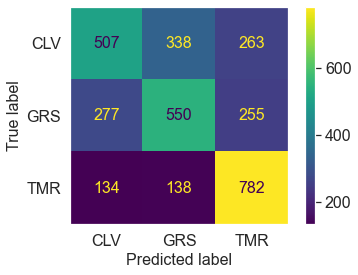

In [145]:
predict_eval(ridge, y, y_pred)

In [146]:
#This function is used repeatedly to compute all metrics
def printMetrics(y, y_pred):
    #classification evaluation measures
    print('\n==============================================================================')
    #print("Accuracy: ", metrics.accuracy_score(y, y_pred))
    #print("Confusion matrix: \n", metrics.confusion_matrix(y, y_pred))
    print("Classification report:\n ", metrics.classification_report(y, y_pred))

In [147]:
#printMetrics(y, ridge_predictions)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

#print("Training data:\n", pd.concat([X_train, y_train], axis=1).head())
#print("\nTest data:\n", pd.concat([X_test, y_test], axis=1).head())
print("Training data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)

Training data shape:  (1946, 1060) (1946,)
Test data shape:  (1298, 1060) (1298,)


X_train:
Accuracy: 0.5760534429599178


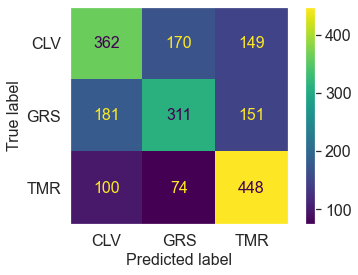


Intercept: 
 [ -1.17224596 -30.6760794   30.84832536]

Features and coeficients: [('col1', array([ 0.24947647,  0.17487266,  0.14099018, ..., -0.28276296,
       -0.28081812, -0.27420264])), ('col2', array([0.64661004, 0.66260573, 0.67634284, ..., 0.00955889, 0.01746   ,
       0.02120377])), ('col3', array([-0.89608651, -0.83747839, -0.81733302, ...,  0.27320407,
        0.26335812,  0.25299887]))]


In [151]:
# Train on the training sample and test on the train and test sample.
ridge = RidgeClassifier().fit(X_train, y_train)
print("X_train:")
y_pred = ridge.predict(X_train)
predict_eval(ridge, y_train, y_pred)

# Print the weights learned for each feature.
print("\nIntercept: \n", ridge.intercept_)
print("\nFeatures and coeficients:", list(zip(features, ridge.coef_))[:10])

In [152]:
#print("Actual vs predicted on training:\n", pd.concat([y_train, pd.DataFrame(train_predictions, columns=['Predicted'], index=y_train.index)], axis=1))
printMetrics(y_train, y_pred)


Classification report:
                precision    recall  f1-score   support

         CLV       0.56      0.53      0.55       681
         GRS       0.56      0.48      0.52       643
         TMR       0.60      0.72      0.65       622

    accuracy                           0.58      1946
   macro avg       0.57      0.58      0.57      1946
weighted avg       0.57      0.58      0.57      1946



X_test:
Accuracy: 0.46687211093990755


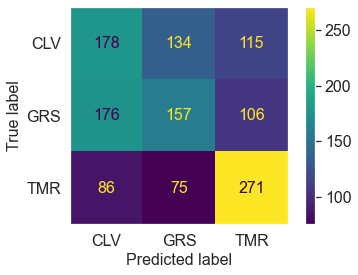


Classification report:
                precision    recall  f1-score   support

         CLV       0.40      0.42      0.41       427
         GRS       0.43      0.36      0.39       439
         TMR       0.55      0.63      0.59       432

    accuracy                           0.47      1298
   macro avg       0.46      0.47      0.46      1298
weighted avg       0.46      0.47      0.46      1298



In [153]:
# Predicted price on test set
print("X_test:")
y_pred = ridge.predict(X_test)
predict_eval(ridge, y_test, y_pred)
printMetrics(y_test, y_pred)
#print("Actual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head().sort_values('kappa_casein'))

In [154]:
error_measures = ['accuracy']
scores = cross_validate(RidgeClassifier(), X, y, scoring=error_measures, cv=3)
scores

{'fit_time': array([0.16421723, 0.192384  , 0.14198995]),
 'score_time': array([0.01627088, 0.01666999, 0.01620507]),
 'test_accuracy': array([0.48983364, 0.5013876 , 0.48843663])}

In [155]:
def printMetricsClassifCV(clf, X, y, metrics = ['acc']):
    #run cross-validation to compute the rmse for different folds, using different regression algorithms
    print('\n==============================================================================')
    scores = cross_validate(clf, X, y, scoring=metrics, cv=4)
    scores
    #print("MAE: ", -scores['test_neg_mean_absolute_error'])
    print("Acc: ", scores['test_accuracy'])

In [156]:
list_clf = [
            #RidgeClassifier(), 
            #RidgeClassifierCV(), 
            #RidgeClassifierCV(normalize=True), 
            RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True), 
            #RidgeClassifierCV(alphas=np.logspace(-4, 4, 10), normalize=True), 
            RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), 
            RidgeClassifierCV(alphas=np.logspace(-6, 6, 10), normalize=True), 
            #RidgeClassifierCV(alphas=np.logspace(-10, 10, 10), normalize=True), 
            #LogisticRegression(penalty='l2'), LogisticRegression(penalty='l1'), 
            #GaussianNB(), 
            LinearDiscriminantAnalysis(), 
            #QuadraticDiscriminantAnalysis(), LinearSVC(),
            #RandomForestClassifier(n_estimators=100), 
            #GradientBoostingClassifier(n_estimators=100),
            #ExtraTreesClassifier(n_estimators=100)
            #RotationForestClassifier(n_estimators=25, n_features_per_subset=3, rotation_algo='randomized'),
            #KNeighborsClassifier(n_neighbors=3),  
            #MLPClassifier(alpha=1, max_iter=1000), 
            #SVC(kernel="linear", C=0.025), 
            #LinearSVC(C=0.001),
            #SVC(C=500.0, kernel="poly", degree=2, coef0=0, gamma=1.0)
            #SVC(gamma=2, C=1)
            ]
            
            
def algoCV(list_clf, X, y, folds = 3, error_measures = ['accuracy']):
    
    algos_df = pd.DataFrame({"algo":[], "acc": []})

    for algo in list_clf:
        print(algo)
        scores = cross_validate(algo, X, y, scoring=error_measures, cv=folds)
        #scores
        acc = scores['test_accuracy']
        fit_time = np.mean(scores['fit_time'])
        score_time = np.mean(scores['score_time'])
        
        algos_df = algos_df.append({"algo":str(algo), "acc": np.mean(acc)}, ignore_index=True)
             
        print("acc: ", acc)
        print("accCV: ", np.mean(acc))
        #print("fit_time: ", fit_time)
        #print("score_time: ", score_time)
        #print("time fit+score:", fit_time + score_time)
        print("\n")
    
    print(algos_df.sort_values('acc', ascending=False))
    algos_df.sort_values('acc').to_csv("cv" + str(folds) + "-acc.csv")
    
if __name__ == "__main__":
    
    algoCV(list_clf, X, y)
    

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)
acc:  [0.75600739 0.73820537 0.73635523]
accCV:  0.7435226619199152


RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                  normalize=True)
acc:  [0.76617375 0.76595745 0.7493062 ]
accCV:  0.760479132361298


RidgeClassifierCV(alphas=array([1.00000000e-06, 2.15443469e-05, 4.64158883e-04, 1.00000000e-02,
       2.15443469e-01, 4.64158883e+00, 1.00000000e+02, 2.15443469e+03,
       4.64158883e+04, 1.00000000e+06]),
                  normalize=True)
acc:  [0.76617375 0.7493062  0.74375578]
accCV:  0.7530785773196699


LinearDiscriminantAnalysis()
acc:  [0.74861368 0.74190564 0.75208

# Findings so far

After comparing several algo with 3-fold cv:
+ RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True) works best, followed closely by LinearDiscriminantAnalysis()


In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

#print("Training data:\n", pd.concat([X_train, y_train], axis=1).head())
#print("\nTest data:\n", pd.concat([X_test, y_test], axis=1).head())
print("Training data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)

Training data shape:  (1946, 1060) (1946,)
Test data shape:  (1298, 1060) (1298,)


Accuracy: 0.7827426810477658


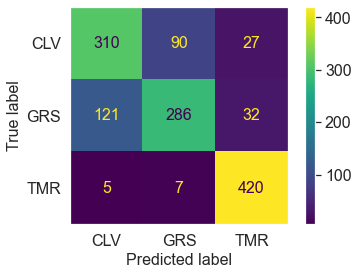

In [160]:
#Without feature selection
clf = Pipeline([
    ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
    #('selector', RFECV(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), step=1, cv=3, scoring='accuracy', n_jobs=-1)),
  ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, y_test, y_pred)

Accuracy: 0.7958397534668721


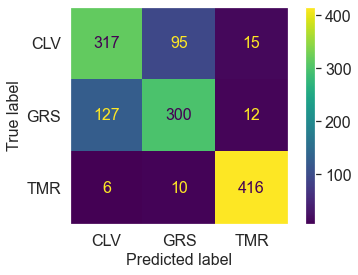

In [161]:
#Without feature selection
clf = Pipeline([
  ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
 #('selector', RFECV(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), step=1, cv=3, scoring='accuracy', n_jobs=-1)),
  ('classification', LinearDiscriminantAnalysis())
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, y_test, y_pred)

Accuracy: 0.7719568567026194


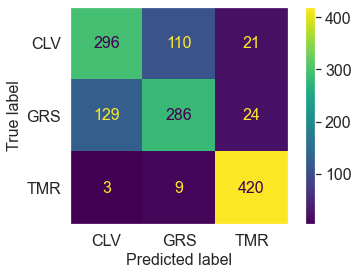

col1 [12.31144564 -8.07238117 -4.23906447]
col2 [-5.60578064 11.69962293 -6.09384229]
col3 [-9.98332534 13.00672642 -3.02340108]
col4 [-2.69742595  2.95022275 -0.2527968 ]
col5 [ 8.10431386 -8.34018146  0.23586759]
col6 [ 14.04802176 -12.54033473  -1.50768702]
col7 [10.59347865 -7.09513985 -3.4983388 ]
col8 [-0.90371311  4.06636483 -3.16265173]
col9 [-14.01713736  13.15782483   0.85931252]
col10 [-21.02476343  13.51311078   7.51165265]
col11 [-17.96267572   4.24383837  13.71883735]
col12 [-7.41387961 -8.96774168 16.38162128]
col13 [  3.4142175  -17.96157836  14.54736086]
col14 [  7.91042006 -18.04174162  10.13132156]
col15 [  4.72546672 -11.38704039   6.66157368]
col16 [-1.5031915 -5.2503626  6.7535541]
col17 [-4.20966845 -5.90895773 10.11862618]
col18 [ -0.50636098 -13.37766356  13.88402454]
col19 [  6.62436765 -21.45686672  14.83249908]
col20 [ 11.03062765 -22.4620534   11.43142575]
col21 [  8.24196433 -12.74233989   4.50037556]
col22 [-1.17419516  4.19801956 -3.0238244 ]
col23 [-12.

col638 [-0.30980946  0.87074873 -0.56093927]
col639 [-2.04120172  1.8325201   0.20868162]
col640 [-1.09882546 -0.10695582  1.20578127]
col641 [ 2.56358151 -1.70312097 -0.86046054]
col642 [ 1.08359018  0.32504567 -1.40863585]
col643 [-1.56084004  0.64853441  0.91230563]
col644 [-0.72676032 -0.49053775  1.21729807]
col645 [ 0.3606873   0.37953527 -0.74022257]
col646 [ 0.40996445  0.36784303 -0.77780748]
col647 [ 0.80999635 -1.30683361  0.49683726]
col648 [-1.36693107  1.06428784  0.30264322]
col649 [-0.99209038  1.35141439 -0.35932401]
col650 [ 3.33244167 -3.30581746 -0.02662421]
col651 [-1.55146164  1.49698944  0.0544722 ]
col652 [-2.21463301  1.95383552  0.26079749]
col653 [ 2.65243955 -3.09928894  0.44684939]
col654 [-0.69395646  1.89697262 -1.20301616]
col655 [-0.78907043  0.60523249  0.18383794]
col656 [ 1.10671321 -2.65947125  1.55275804]
col657 [-0.28487741  1.2874779  -1.00260048]
col658 [-0.17585809  0.87894592 -0.70308784]
col659 [-0.26922264 -0.9402602   1.20948284]
col660 [-0

In [162]:
clf = RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(ridge, y_test, y_pred)

for idx in range(0, len(features)):
    #if selector.get_support()[idx]:
    print(features[idx], clf.coef_[:,idx])

Accuracy: 0.8258859784283513


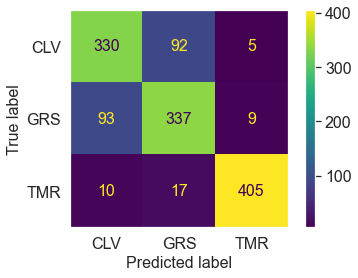


Classification report:
                precision    recall  f1-score   support

         CLV       0.76      0.77      0.77       427
         GRS       0.76      0.77      0.76       439
         TMR       0.97      0.94      0.95       432

    accuracy                           0.83      1298
   macro avg       0.83      0.83      0.83      1298
weighted avg       0.83      0.83      0.83      1298



In [163]:
#Testing feature selection
#th = "median"
th = "mean"

clf = Pipeline([
   # ('scaler', StandardScaler()),
   # ('feature selector', SelectKBest(mutual_info_classif, k=800)),
    ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), threshold = th)),  
     ('fpoly', PolynomialFeatures(degree=2)),
  #  ('feature_selection2', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), threshold = th)),  
   #("fspline", SplineTransformer(n_knots=4, degree=3)),
 # ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
     ('classification', LinearDiscriminantAnalysis())
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, y_test, y_pred)
printMetrics(y_test, y_pred)

In [164]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), threshold = "median")),
   #('selector', RFECV(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), step=1, cv=3, scoring='accuracy', n_jobs=-1)),
    ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
])
algo = clf
folds = 3
print(algo)

scores = cross_validate(algo, X, y, scoring=error_measures, cv=folds)
#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
print("time fit+score:", fit_time + score_time)
print("\n")

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                                             normalize=True),
                                 threshold='median')),
                ('classification',
                 RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                   normalize=True))])
acc:  [0.77449168 0.78168363 0.75670675]
accCV:  0.7709606871162288
time fit+score: 1.0814580122629802




Accuracy: 0.8258859784283513


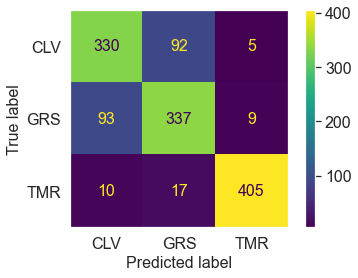


Classification report:
                precision    recall  f1-score   support

         CLV       0.76      0.77      0.77       427
         GRS       0.76      0.77      0.76       439
         TMR       0.97      0.94      0.95       432

    accuracy                           0.83      1298
   macro avg       0.83      0.83      0.83      1298
weighted avg       0.83      0.83      0.83      1298



In [107]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), threshold = "mean")),
  ('fpoly', PolynomialFeatures(degree=2)),
    ('classification', LinearDiscriminantAnalysis())
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predict_eval(clf, y_test, y_pred)
printMetrics(y_test, y_pred)

In [108]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
    ('fpoly', PolynomialFeatures(degree=2)),
  ('classification', LinearDiscriminantAnalysis())
])
algo = clf
folds = 3
print(algo)

scores = cross_validate(algo, X, y, scoring=error_measures, cv=folds)
#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
print("time fit+score:", fit_time + score_time)
print("\n")

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                                             normalize=True))),
                ('fpoly', PolynomialFeatures()),
                ('classification', LinearDiscriminantAnalysis())])
acc:  [0.84565619 0.84273821 0.84458834]
accCV:  0.8443275805759369
time fit+score: 98.71487124760945




In [109]:
selector = SelectFromModel(estimator=RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True)).fit(X_train, y_train)
#selector.estimator_.coef_
print("threshold: ", selector.threshold_)
print("number of selected features: ", selector.get_support().sum())
print("coefs: ", selector.estimator_.coef_)
#selector.get_support()

threshold:  56.785128240863685
number of selected features:  312
coefs:  [[ 12.31144564  -5.60578064  -9.98332534 ... -11.12499045 -15.53104525
  -16.16260089]
 [ -8.07238117  11.69962293  13.00672642 ...   8.123713    12.66065365
   15.77988069]
 [ -4.23906447  -6.09384229  -3.02340108 ...   3.00127745   2.8703916
    0.38272021]]


In [165]:
#selector = RFECV(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), step=1, cv=3, scoring='accuracy', n_jobs=-1)),
#print("threshold: ", selector.threshold_)
#print("number of selected features: ", selector.get_support().sum())
#print("coefs: ", selector.estimator_.coef_)

In [166]:
#for idx in range(0, len(selector.get_support())):
    #if selector.get_support()[idx]:
#    print(features[idx], selector.estimator_.coef_[:,idx])

In [167]:
#import numpy.ma as ma
#features_selected = ma.masked_where(selector.get_support(), features)
#for idx in range(0, len(selector.get_support())):
#    if selector.get_support()[idx]:
#        print(features[idx])

In [193]:
for idx in range(0, len(selector.get_support())):
    if selector.get_support()[idx]:
        print(features[idx], selector.estimator_.coef_[:,idx])

col44 [-18.14038427  46.43425098 -28.29386671]
col45 [-18.1276669   61.23271929 -43.10505239]
col46 [-18.04197323  62.68677025 -44.64479701]
col47 [-17.68150463  47.30572142 -29.62421679]
col50 [ -3.01063855 -43.82477411  46.83541266]
col51 [  8.5688952  -57.67733198  49.10843678]
col52 [ 22.24672177 -52.61853357  30.3718118 ]
col53 [ 35.1834579  -30.17320138  -5.01025652]
col54 [ 42.62787185   2.30475857 -44.93263042]
col55 [ 39.16135857  32.45077901 -71.61213758]
col56 [ 24.14829422  46.68279585 -70.83109007]
col57 [  5.57311987  40.82955518 -46.40267505]
col72 [ 41.35430959   3.27261654 -44.62692613]
col73 [ 57.63519549  -8.45066193 -49.18453355]
col74 [ 47.85294709 -19.75587394 -28.09707315]
col76 [-47.72283434  -1.13379042  48.85662475]
col77 [-77.14840055  19.76114351  57.38725705]
col78 [-67.97111447  32.48564013  35.48547435]
col79 [-30.34450459  32.89612391  -2.55161933]
col80 [ 14.83970398  23.84496948 -38.68467346]
col81 [ 50.70099291   9.70723243 -60.40822533]
col82 [ 68.89

col896 [-32.48438254  20.98896819  11.49541435]
col897 [-37.44386903  23.77996337  13.66390567]
col898 [-30.90803732  17.93420323  12.97383409]
col906 [-34.53416941  28.59654038   5.93762903]
col907 [-35.80151741  28.6782828    7.1232346 ]
col908 [-29.29247243  23.02991943   6.262553  ]


# Findings so far

After comparing several algo with 3-fold cv:
+ RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True) works best, followed closely by LinearDiscriminantAnalysis()
+ FeatureSelection using SelectFromModel improves the Acc by 1.5%.

In [168]:
class IntervalSelector(BaseEstimator, TransformerMixin):
    # initializer 
    def __init__(self, start = 0, end = 10, return_timeseries = True):        
        self.start = start
        self.end = end
        self.return_timeseries = return_timeseries
            
            
    def fit(self, X, y = None):        
        return self    
    
    def transform(self, X, y = None):             
        if self.return_timeseries:
            return from_2d_array_to_nested(X.iloc[:,self.start:self.end])
        else:
            return X.iloc[:,self.start:self.end]

----------------------
Interval: 0 - 171
----------------------
Accuracy: 0.714175654853621


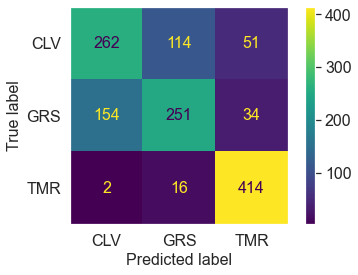

----------------------
Interval: 206 - 535
----------------------
Accuracy: 0.734206471494607


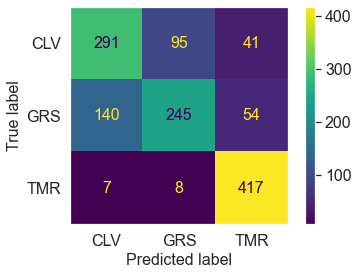

----------------------
Interval: 729 - 747
----------------------
Accuracy: 0.3320493066255778


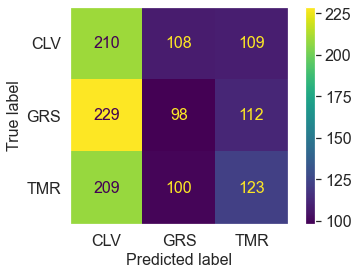

In [169]:
#Water region removal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

intervals = [(0,171),(206,535),(729,747)]
results = {}

for itv_start, itv_end in intervals:
    print('----------------------')
    print(f'Interval: {itv_start} - {itv_end}')
    print('----------------------')
    chopper = IntervalSelector(itv_start,itv_end,return_timeseries = False)
    X_train_itv = chopper.transform(X_train)
    X_test_itv = chopper.transform(X_test)
    
    clf = Pipeline([
      #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
    clf.fit(X_train_itv, y_train)
    y_pred = clf.predict(X_test_itv)
    predict_eval(clf, y_test, y_pred)

Accuracy: 0.7835130970724191


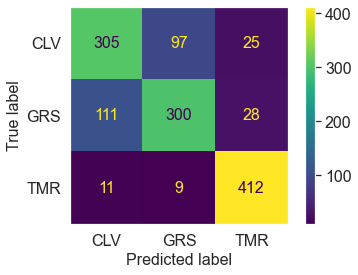

In [170]:
X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535, 729:747]]
X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535, 729:747]]

#X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535]]
#X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535]]


clf = Pipeline([
    ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
    #('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True, class_weight='balanced'))
    ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
clf.fit(X_train_no_water, y_train)
y_pred = clf.predict(X_test_no_water)
predict_eval(clf, y_test, y_pred)

Accuracy: 0.7950693374422187


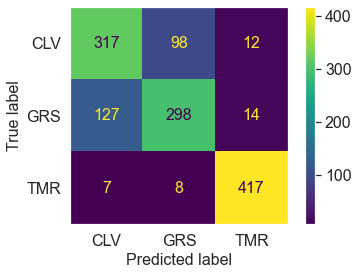

In [171]:
X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535, 729:747]]
X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535, 729:747]]
#X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535]]
#X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535]]
#X_train_no_water = X_train.iloc[:, np.r_[0:171]]
#X_test_no_water = X_test.iloc[:, np.r_[0:171]]


clf = Pipeline([
      #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', LinearDiscriminantAnalysis())
    ])
clf.fit(X_train_no_water, y_train)
y_pred = clf.predict(X_test_no_water)
predict_eval(clf, y_test, y_pred)

In [54]:

clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
       ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])

algo = clf
folds = 3
print(algo)

#scores = cross_validate(algo, X.iloc[:, np.r_[0:171, 206:535, 729:747]], y, scoring=error_measures, cv=folds)
scores = cross_validate(algo, X.iloc[:, np.r_[0:171, 206:535]], y, scoring=error_measures, cv=folds)


#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
print("time fit+score:", fit_time + score_time)
print("\n")

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                                             normalize=True))),
                ('classification',
                 RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                   normalize=True))])
acc:  [0.77356747 0.7826087  0.75208141]
accCV:  0.7694191898033758
time fit+score: 0.3546326955159505




In [56]:
#X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:306, 728:747]]
#X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:306, 728:747]]

clf = Pipeline([
     # ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', LinearDiscriminantAnalysis())
    ])

algo = clf
folds = 3
print(algo)

#scores = cross_validate(algo, X.iloc[:, np.r_[0:171, 206:535, 729:747]], y, scoring=error_measures, cv=folds)
scores = cross_validate(algo, X.iloc[:, np.r_[0:171, 206:535]], y, scoring=error_measures, cv=folds)

#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
#print("time fit+score:", fit_time + score_time)
print("\n")

Pipeline(steps=[('classification', LinearDiscriminantAnalysis())])
acc:  [0.78003697 0.78723404 0.76688252]
accCV:  0.7780511757728719
time fit+score: 0.2678130467732747




----------------------
Interval: 0 - 171
----------------------
Accuracy: 0.687211093990755


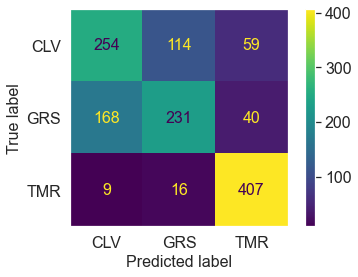

----------------------
Interval: 206 - 535
----------------------
Accuracy: 0.714175654853621


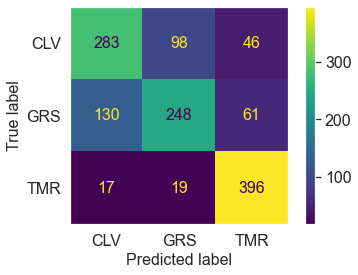

----------------------
Interval: 729 - 747
----------------------
Accuracy: 0.33975346687211094


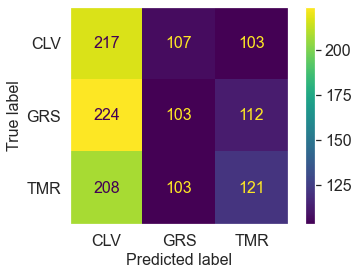

In [172]:
#Water region removal + feature selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

intervals = [(0,171),(206,535),(729,747)]
results = {}

for itv_start, itv_end in intervals:
    print('----------------------')
    print(f'Interval: {itv_start} - {itv_end}')
    print('----------------------')
    chopper = IntervalSelector(itv_start,itv_end,return_timeseries = False)
    X_train_itv = chopper.transform(X_train)
    X_test_itv = chopper.transform(X_test)
    
    clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
    clf.fit(X_train_itv, y_train)
    y_pred = clf.predict(X_test_itv)
    predict_eval(clf, y_test, y_pred)

Accuracy: 0.7842835130970724


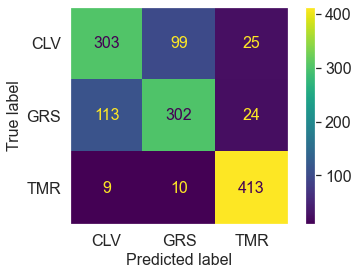

In [173]:
X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535, 729:747]]
X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535, 729:747]]

clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
      ('fpoly', PolynomialFeatures(degree=2)),
      ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
    ])
clf.fit(X_train_no_water, y_train)
y_pred = clf.predict(X_test_no_water)
predict_eval(clf, y_test, y_pred)

Accuracy: 0.8328197226502311


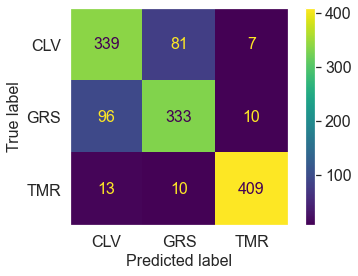

In [174]:
X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535, 729:747]]
X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535, 729:747]]
#X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:535]]
#X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:535]]
#X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:306]]
#X_test_no_water = X_test.iloc[:, np.r_[0:171, 206:306]]


clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
       ('fpoly', PolynomialFeatures(degree=2)),
      ('classification', LinearDiscriminantAnalysis())
    ])
clf.fit(X_train_no_water, y_train)
y_pred = clf.predict(X_test_no_water)
predict_eval(clf, y_test, y_pred)

In [175]:
clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
     ('fpoly', PolynomialFeatures(degree=2)),
      ('classification', LinearDiscriminantAnalysis())
    ])

algo = clf
folds = 3
print(algo)

scores = cross_validate(algo, X.iloc[:, np.r_[0:171, 206:535, 729:747]], y, scoring=error_measures, cv=folds)
#scores = cross_validate(algo, X.iloc[:, np.r_[0:171, 206:535]], y, scoring=error_measures, cv=folds)

#scores
acc = scores['test_accuracy']
fit_time = np.mean(scores['fit_time'])
score_time = np.mean(scores['score_time'])
print("acc: ", acc)
print("accCV: ", np.mean(acc))
#print("fit_time: ", fit_time)
#print("score_time: ", score_time)
print("time fit+score:", fit_time + score_time)
print("\n")

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                                             normalize=True))),
                ('fpoly', PolynomialFeatures()),
                ('classification', LinearDiscriminantAnalysis())])
acc:  [0.84288355 0.85291397 0.83626272]
accCV:  0.8440200790783278
time fit+score: 41.48094455401103




# Findings so far

After comparing several algo with 3-fold cv:
+ RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True) works best, followed closely by LinearDiscriminantAnalysis()
+ FeatureSelection using SelectFromModel improves the Acc by 1.5%.
+Best result so far: original data + feature selection (SelectFromModel()) + Ridge or LDA

In [176]:
# Try some noise removal before feature selection and learning
# Ranking windows to do automatic water region removal
# Ideas to test: contiguous windows of fixed size, contiguous windows of random size, non-contiguous windows (essentially random feature subset selection of varying size)
def rankedWindows(X, y, runs, windowSize, classifier):

    results = {}
    
    if len(X.columns) % windowSize == 0:
        numberOfWindows = len(X.columns) // windowSize
    else:
        numberOfWindows = (len(X.columns) // windowSize) + 1
    
    print(numberOfWindows)
    
    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.4, random_state = 0)
        
    for k in range(1, runs+1):

        #print(f"Run {k}")

        validationScores = []
        
        xTrainSplit, xValidate, yTrainSplit, yValidate = train_test_split(xTrain, yTrain, test_size=0.4)

        for n in range(0, numberOfWindows):               
            windowStart = n * windowSize
            windowEnd = windowStart + windowSize
            if windowEnd > len(X.columns): 
                windowEnd = len(X.columns)          
            #print("windowStart:", windowStart)
            #print("windowEnd:", windowEnd)
            
            xTrainWindow = xTrainSplit.iloc[:,windowStart:windowEnd]
            xValidateWindow = xValidate.iloc[:,windowStart:windowEnd]
            
            if (classifier == "MiniRocket"):
                xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
                xValidateWindowSeries = from_2d_array_to_nested(xValidateWindow)

                minirocket = MiniRocket()
                minirocket.fit(xTrainWindowSeries)
                xTrainTransform = minirocket.transform(xTrainWindowSeries)
                clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
                clf.fit(xTrainTransform, yTrainSplit)
                xValidateTransform = minirocket.transform(xValidateWindowSeries)
                y_pred = clf.predict(xValidateTransform)
                score = accuracy_score(y_pred, yValidate)
            
            
            elif (classifier == "RidgeClassifierCV"):
                clf = RidgeClassifierCV(alphas=np.logspace(-6, 6, 10), normalize=True)
                clf.fit(xTrainWindow, yTrainSplit)
                y_pred = clf.predict(xValidateWindow)
                score = accuracy_score(y_pred, yValidate)
                
            validationScores.append(score)
            #print(validationScores)
            #print(windowStart, windowEnd)
            #print(score)
            
    
        for n in range(0, numberOfWindows):
            if n in results:
                results[n] += validationScores[n]
            else:
                results[n] = validationScores[n]
            #print(results)
             
        #print(results)       
                   
    #print(validationScores)
    for n in range(0, numberOfWindows):
        results[n] = results[n] / runs
    #print(results)
    
    sortedResults = sorted(results.items(), key=lambda x: x[1], reverse=True)
    
    updatedKeyResults = {}
    for key, value in results.items():
        newKeyStart = key*windowSize
        newKeyEnd = newKeyStart + windowSize
        if newKeyEnd > len(X.columns): 
                newKeyEnd = len(X.columns) 
        updatedKeyResults[f"{newKeyStart}:{newKeyEnd}"] = value
        
    sortedResults = sorted(updatedKeyResults.items(), key=lambda x: x[1], reverse=True)
    return sortedResults

In [177]:
ridge_windows = rankedWindows(X, y, runs = 5, windowSize = 50, classifier = "RidgeClassifierCV")

22


In [178]:
ridge_windows

[('100:150', 0.6331193838254172),
 ('0:50', 0.6205391527599486),
 ('500:550', 0.5810012836970475),
 ('50:100', 0.5658536585365853),
 ('450:500', 0.5571245186136072),
 ('200:250', 0.47753530166880614),
 ('250:300', 0.43876765083440306),
 ('300:350', 0.41745827984595635),
 ('150:200', 0.41540436456996155),
 ('400:450', 0.4128369704749678),
 ('900:950', 0.38228498074454426),
 ('850:900', 0.37997432605905007),
 ('350:400', 0.3779204107830552),
 ('750:800', 0.3676508344030809),
 ('800:850', 0.36251604621309375),
 ('700:750', 0.3589216944801027),
 ('550:600', 0.35661103979460845),
 ('1000:1050', 0.3558408215661104),
 ('950:1000', 0.34967907573812584),
 ('1050:1060', 0.34582798459563546),
 ('650:700', 0.34531450577663675),
 ('600:650', 0.34017971758664955)]

In [179]:
# given a list of ranked windows, return the index of columns included in the windows up to a given window
# eg for index = 1, return the columns corresponding to the first window, for idx = 2, return columns for first 2 windows
def evalWindows(ridge_windows, idx):
#idx = 22

    #print("idx: ", idx)
    subset_columns = np.array([])

    for w in ridge_windows[:idx]:
        #print(w[0])
        start = int(w[0].split(':')[0])
        end = int(w[0].split(':')[1])
        #if end > len(X.columns): 
        #    end = len(X.columns)
        #print(np.r_[start+1:end+1])
        #print(X_train.iloc[:, np.r_[start:end]].columns)
        #print(X_train.iloc[:, np.r_[start:end]].columns.to_list())
        #subset_columns = subset_columns.union(X_train.iloc[:, np.r_[start:end]].columns)
        subset_columns = np.concatenate((subset_columns, np.array(np.r_[start+1:end+1])), axis=None)
    
    #print(subset_columns)
    #print(np.sort(subset_columns))

    subset_columns = np.sort(subset_columns)

    #print(["col" + str(int(item)) for item in subset_columns])
    subset_index = pd.Index(["col" + str(int(item)) for item in subset_columns])
    #print(subset_index)
    return subset_index 
    

In [180]:
ridge_windows = rankedWindows(X, y, runs = 5, windowSize = 50, classifier = "RidgeClassifierCV")
algos_df = pd.DataFrame({"window_idx":[], "acc": []})

for idx in range(1,len(ridge_windows)+1):
    subset_index = evalWindows(ridge_windows, idx)

    X_train_auto_windows = X_train[subset_index]
    X_test_auto_windows = X_test[subset_index]

    clf = Pipeline([
          ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
          ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
        ])
    clf.fit(X_train_auto_windows, y_train)
    y_pred = clf.predict(X_test_auto_windows)
    #predict_eval(clf, y_test, y_pred)
    algos_df = algos_df.append({"window_idx":str(idx), "acc": accuracy_score(y_test, y_pred)}, ignore_index=True)
    
print(algos_df.sort_values('acc', ascending=False))
    

22
   window_idx       acc
11         12  0.790447
8           9  0.790447
10         11  0.785824
13         14  0.785054
12         13  0.784284
21         22  0.782743
19         20  0.781202
20         21  0.781202
9          10  0.778891
18         19  0.778891
16         17  0.778120
14         15  0.775039
15         16  0.775039
17         18  0.774268
6           7  0.755778
7           8  0.755778
4           5  0.732666
5           6  0.723421
2           3  0.718028
3           4  0.708783
1           2  0.688752
0           1  0.628659


In [181]:
# evaluate the best idx for ranked windows and rank in order of accuracy
ridge_windows = rankedWindows(X, y, runs = 5, windowSize = 90, classifier = "RidgeClassifierCV")

algos_df = pd.DataFrame({"window_idx":[], "acc": []})

for idx in range(1,len(ridge_windows)+1):
    subset_index = evalWindows(ridge_windows, idx)

    X_train_auto_windows = X_train[subset_index]
    X_test_auto_windows = X_test[subset_index]

    clf = Pipeline([
          ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
        #('feature_selection', SelectKBest(k = 50)),    
        ('classification', LinearDiscriminantAnalysis())
        ])
    clf.fit(X_train_auto_windows, y_train)
    y_pred = clf.predict(X_test_auto_windows)
    #predict_eval(clf, y_test, y_pred)
    algos_df = algos_df.append({"window_idx":str(idx), "acc": accuracy_score(y_test, y_pred)}, ignore_index=True)
    
print(algos_df.sort_values('acc', ascending=False))
    

12
   window_idx       acc
9          10  0.805085
8           9  0.801233
10         11  0.798921
11         12  0.795840
4           5  0.786595
7           8  0.786595
6           7  0.783513
5           6  0.782743
2           3  0.731125
3           4  0.721880
1           2  0.716487
0           1  0.645609


In [180]:
ridge_windows = rankedWindows(X, y, runs = 5, windowSize = 90, classifier = "RidgeClassifierCV")

algos_df = pd.DataFrame({"window_idx":[], "acc": []})

for idx in range(1,len(ridge_windows)+1):
    
    subset_index = evalWindows(ridge_windows, idx)
     
    #X_train_auto_windows = X_train[subset_index]
    #X_test_auto_windows = X_test[subset_index]
    
    clf = Pipeline([
      ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
        ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
      #('classification', LinearDiscriminantAnalysis())
    ])

    algo = clf
    folds = 3
    #print(algo)

    scores = cross_validate(algo, X[subset_index], y, scoring=error_measures, cv=folds)
    #scores
    acc = scores['test_accuracy']
    fit_time = np.mean(scores['fit_time'])
    score_time = np.mean(scores['score_time'])
    #print("acc: ", acc)
    #print("accCV: ", np.mean(acc))
    algos_df = algos_df.append({"window_idx":str(idx), "acc": np.mean(acc)}, ignore_index=True)
    
    #print("fit_time: ", fit_time)
    #print("score_time: ", score_time)
    #print("time fit+score:", fit_time + score_time)
    #print("\n")
    
print(algos_df.sort_values('acc', ascending=False))
#algos_df.sort_values('acc').to_csv("cv" + str(folds) + "-acc.csv")
    

12
   window_idx       acc
10         11  0.777741
11         12  0.777434
9          10  0.777124
6           7  0.775892
8           9  0.773735
7           8  0.771576
5           6  0.769421
4           5  0.766644
3           4  0.716398
2           3  0.708386
1           2  0.692041
0           1  0.638710


In [218]:
for wlength in range(10, 101, 10):
    print("window size: ", wlength)
    ridge_windows = rankedWindows(X, y, runs = 5, windowSize = wlength, classifier = "RidgeClassifierCV")
    print(ridge_windows[:10])
    
    algos_df = pd.DataFrame({"window_idx":[], "acc": []})

    for idx in range(1,len(ridge_windows)+1):
        subset_index = evalWindows(ridge_windows, idx)

        X_train_auto_windows = X_train[subset_index]
        X_test_auto_windows = X_test[subset_index]

        clf = Pipeline([
          ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
          ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
        ])
        clf.fit(X_train_auto_windows, y_train)
        y_pred = clf.predict(X_test_auto_windows)
        #predict_eval(clf, y_test, y_pred)
        algos_df = algos_df.append({"window_idx":str(idx), "acc": accuracy_score(y_test, y_pred)}, ignore_index=True)
    
    print(algos_df.sort_values('acc', ascending=False))

window size:  10
106
[('130:140', 0.5478818998716304), ('0:10', 0.54403080872914), ('10:20', 0.5250320924261874), ('140:150', 0.5152759948652118), ('120:130', 0.500385109114249), ('490:500', 0.4806161745827985), ('100:110', 0.4664955070603337), ('70:80', 0.45879332477535295), ('80:90', 0.4510911424903723), ('520:530', 0.4369704749679076)]
    window_idx       acc
55          56  0.796610
64          65  0.796610
58          59  0.795840
71          72  0.795069
72          73  0.794299
56          57  0.794299
57          58  0.794299
65          66  0.792758
54          55  0.792758
73          74  0.792758
74          75  0.792758
62          63  0.791988
61          62  0.791988
69          70  0.791217
70          71  0.791217
53          54  0.791217
63          64  0.789676
67          68  0.789676
60          61  0.788136
68          69  0.787365
48          49  0.787365
50          51  0.787365
59          60  0.787365
51          52  0.787365
49          50  0.786595
92       

[('70:140', 0.6349165596919126), ('0:70', 0.6182284980744543), ('490:560', 0.5848523748395379), ('140:210', 0.5388960205391528), ('420:490', 0.5016688061617458), ('210:280', 0.4590500641848524), ('280:350', 0.4503209242618742), ('350:420', 0.3943517329910141), ('840:910', 0.386392811296534), ('910:980', 0.379204107830552)]
   window_idx       acc
8           9  0.791217
7           8  0.786595
9          10  0.784284
10         11  0.784284
14         15  0.783513
15         16  0.782743
13         14  0.779661
11         12  0.778120
12         13  0.775809
6           7  0.773498
4           5  0.722650
3           4  0.721109
5           6  0.720339
2           3  0.714946
1           2  0.685670
0           1  0.621726
window size:  80
14
[('80:160', 0.6590500641848525), ('0:80', 0.6364569961489088), ('480:560', 0.5817715019255456), ('160:240', 0.5080872913992297), ('240:320', 0.4729139922978177), ('400:480', 0.43517329910141206), ('320:400', 0.4028241335044929), ('880:960', 0.3884

In [209]:
for wlength in range(10, 101, 10):
    print("window size: ", wlength)
    ridge_windows = rankedWindows(X, y, runs = 5, windowSize = wlength, classifier = "RidgeClassifierCV")
    print(ridge_windows[:5])
    
    algos_df = pd.DataFrame({"window_idx":[], "acc": []})

    for idx in range(1,len(ridge_windows)+1):
        subset_index = evalWindows(ridge_windows, idx)

        X_train_auto_windows = X_train[subset_index]
        X_test_auto_windows = X_test[subset_index]

        clf = Pipeline([
         # ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
          ('classification', LinearDiscriminantAnalysis())
        ])
        clf.fit(X_train_auto_windows, y_train)
        y_pred = clf.predict(X_test_auto_windows)
        #predict_eval(clf, y_test, y_pred)
        algos_df = algos_df.append({"window_idx":str(idx), "acc": accuracy_score(y_test, y_pred)}, ignore_index=True)
    
    print(algos_df.sort_values('acc', ascending=False))

window size:  10
106
[('130:140', 0.5668806161745829), ('0:10', 0.5507060333761233), ('10:20', 0.5296534017971759), ('140:150', 0.5111681643132221), ('120:130', 0.5037227214377407)]
    window_idx       acc
48          49  0.796610
46          47  0.794299
60          61  0.794299
58          59  0.794299
47          48  0.794299
59          60  0.793529
57          58  0.791988
49          50  0.791217
31          32  0.790447
61          62  0.789676
52          53  0.789676
51          52  0.789676
45          46  0.789676
30          31  0.788906
50          51  0.788906
44          45  0.788136
53          54  0.788136
55          56  0.787365
29          30  0.787365
56          57  0.787365
34          35  0.787365
33          34  0.786595
54          55  0.785054
32          33  0.785054
63          64  0.783513
62          63  0.783513
43          44  0.783513
40          41  0.783513
39          40  0.783513
41          42  0.783513
35          36  0.781202
65          66  0.

KeyboardInterrupt: 

In [183]:
for wlength in range(50, 101, 10):
    print("window size: ", wlength)
    ridge_windows = rankedWindows(X, y, runs = 5, windowSize = wlength, classifier = "RidgeClassifierCV")
    print(ridge_windows[:10])

    algos_df = pd.DataFrame({"window_idx":[], "acc": []})

    for idx in range(1,len(ridge_windows)+1):
    
        subset_index = evalWindows(ridge_windows, idx)
     
        clf = Pipeline([
            ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
            ('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
              #('classification', LinearDiscriminantAnalysis())
        ])

        algo = clf
        folds = 3
        #print(algo)

        scores = cross_validate(algo, X[subset_index], y, scoring=error_measures, cv=folds)
        #scores
        acc = scores['test_accuracy']
        fit_time = np.mean(scores['fit_time'])
        score_time = np.mean(scores['score_time'])
        #print("acc: ", acc)
        #print("accCV: ", np.mean(acc))
        algos_df = algos_df.append({"window_idx":str(idx), "acc": np.mean(acc)}, ignore_index=True)
    
        #print("fit_time: ", fit_time)
        #print("score_time: ", score_time)
        #print("time fit+score:", fit_time + score_time)
        #print("\n")
    
    print(algos_df.sort_values('acc', ascending=False))

window size:  50
22
[('100:150', 0.6279845956354301), ('0:50', 0.6148908857509628), ('500:550', 0.5537869062901155), ('50:100', 0.5499358151476251), ('450:500', 0.5442875481386393), ('200:250', 0.47445442875481386), ('250:300', 0.42670089858793325), ('150:200', 0.41874197689345316), ('300:350', 0.40256739409499354), ('350:400', 0.3953786906290116)]
   window_idx       acc
20         21  0.778976
17         18  0.778049
16         17  0.777741
21         22  0.777434
19         20  0.776507
13         14  0.776201
15         16  0.774968
10         11  0.774660
18         19  0.774659
14         15  0.774658
12         13  0.772809
9          10  0.772504
11         12  0.770341
8           9  0.767878
6           7  0.754933
7           8  0.753699
5           6  0.713317
4           5  0.709311
3           4  0.707766
2           3  0.696052
1           2  0.661828
0           1  0.625766
window size:  60
18
[('120:180', 0.6146341463414634), ('0:60', 0.6143774069319641), ('480:540', 0

In [182]:
#for wlength in range(10, 101, 10):
for wlength in [90]:
    print("window size: ", wlength)
    ridge_windows = rankedWindows(X, y, runs = 5, windowSize = wlength, classifier = "RidgeClassifierCV")
    print(ridge_windows[:10])

    algos_df = pd.DataFrame({"window_idx":[], "acc": []})

    for idx in range(1,len(ridge_windows)+1):
    
        subset_index = evalWindows(ridge_windows, idx)
     
        clf = Pipeline([
            ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
            #('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
            #('fpoly', PolynomialFeatures(degree=2)),
            ('classification', LinearDiscriminantAnalysis())
        ])

        algo = clf
        folds = 3
        #print(algo)

        scores = cross_validate(algo, X[subset_index], y, scoring=error_measures, cv=folds)
        #scores
        acc = scores['test_accuracy']
        fit_time = np.mean(scores['fit_time'])
        score_time = np.mean(scores['score_time'])
        #print("acc: ", acc)
        #print("accCV: ", np.mean(acc))
        algos_df = algos_df.append({"window_idx":str(idx), "acc": np.mean(acc)}, ignore_index=True)
    
        #print("fit_time: ", fit_time)
        #print("score_time: ", score_time)
        #print("time fit+score:", fit_time + score_time)
        #print("\n")
    
    print(algos_df.sort_values('acc', ascending=False))

window size:  90
12
[('90:180', 0.6575096277278563), ('0:90', 0.6354300385109115), ('450:540', 0.6007702182284981), ('180:270', 0.47394094993581515), ('270:360', 0.4582798459563543), ('360:450', 0.43440308087291396), ('720:810', 0.3845956354300385), ('810:900', 0.38305519897304235), ('900:990', 0.37663671373555835), ('990:1060', 0.36585365853658536)]
   window_idx       acc
7           8  0.780824
8           9  0.780517
10         11  0.779285
11         12  0.778666
6           7  0.776819
5           6  0.775281
9          10  0.775277
4           5  0.767264
3           4  0.723179
2           3  0.721637
1           2  0.703135
0           1  0.646107


# Make predictions using best model on the test data

idx = 10, wsize = 90

clf = Pipeline([

            ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
            
            ('classification', LinearDiscriminantAnalysis())
        ])

In [183]:
training_df.shape

(3244, 1061)

12
X_train
Accuracy: 0.9578622816032888


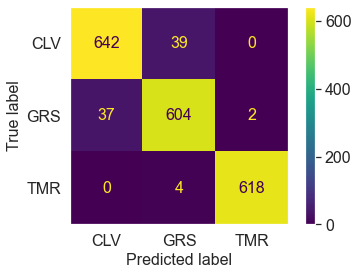


Classification report:
                precision    recall  f1-score   support

         CLV       0.95      0.94      0.94       681
         GRS       0.93      0.94      0.94       643
         TMR       1.00      0.99      1.00       622

    accuracy                           0.96      1946
   macro avg       0.96      0.96      0.96      1946
weighted avg       0.96      0.96      0.96      1946

train60 class distrib:
 CLV    681
GRS    643
TMR    622
Name: Diet, dtype: int64
train60 class distrib:
 CLV    0.349949
GRS    0.330421
TMR    0.319630
Name: Diet, dtype: float64
train60 predicted class distrib:
 CLV    679
GRS    647
TMR    620
dtype: int64
train60 predicted class distrib:
 CLV    0.348921
GRS    0.332477
TMR    0.318602
dtype: float64
X_test
Accuracy: 0.8235747303543913


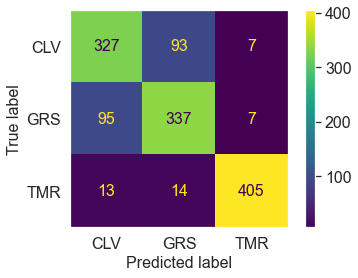


Classification report:
                precision    recall  f1-score   support

         CLV       0.75      0.77      0.76       427
         GRS       0.76      0.77      0.76       439
         TMR       0.97      0.94      0.95       432

    accuracy                           0.82      1298
   macro avg       0.83      0.82      0.82      1298
weighted avg       0.83      0.82      0.82      1298

test40 class distrib:
 CLV    427
GRS    439
TMR    432
Name: Diet, dtype: int64
test40 class distrib:
 CLV    0.328968
GRS    0.338213
TMR    0.332820
Name: Diet, dtype: float64
test40 predicted class distrib:
 CLV    435
GRS    444
TMR    419
dtype: int64
test40 predicted class distrib:
 CLV    0.335131
GRS    0.342065
TMR    0.322804
dtype: float64
['GRS' 'CLV' 'GRS' ... 'CLV' 'GRS' 'GRS']
final test pred class distrib:
 CLV    384
GRS    355
TMR    338
dtype: int64
final test pred class distrib:
 CLV    0.356546
GRS    0.329619
TMR    0.313835
dtype: float64
  Diet      col1      co

In [190]:
# Auto windows removal, feature selection, poly2, LDA
ridge_windows = rankedWindows(X, y, runs = 5, windowSize = 90, classifier = "RidgeClassifierCV")

#algos_df = pd.DataFrame({"window_idx":[], "acc": []})

#for idx in range(1,len(ridge_windows)+1):
#take the best window size and idx of windows to use
subset_index = evalWindows(ridge_windows, idx = 10)

X_train_auto_windows = X_train[subset_index]
X_test_auto_windows = X_test[subset_index]

clf = Pipeline([
         ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
         #('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
        #('feature_selection', SelectKBest(k = 50)),    
        ('fpoly', PolynomialFeatures(degree=2)),
        ('classification', LinearDiscriminantAnalysis())
        ])

clf.fit(X_train_auto_windows, y_train)
print("X_train")
y_pred = clf.predict(X_train_auto_windows)
predict_eval(clf, y_train, y_pred)
printMetrics(y_train, y_pred)
print("train60 class distrib:\n", y_train.value_counts().sort_index(ascending=True))
print("train60 class distrib:\n", y_train.value_counts(normalize=True).sort_index(ascending=True))
print("train60 predicted class distrib:\n", pd.DataFrame(y_pred).value_counts().sort_index(ascending=True))
print("train60 predicted class distrib:\n", pd.DataFrame(y_pred).value_counts(normalize=True).sort_index(ascending=True))

print("X_test")
y_pred = clf.predict(X_test_auto_windows)
predict_eval(clf, y_test, y_pred)
printMetrics(y_test, y_pred)
print("test40 class distrib:\n", y_test.value_counts().sort_index(ascending=True))
print("test40 class distrib:\n", y_test.value_counts(normalize=True).sort_index(ascending=True))
print("test40 predicted class distrib:\n", pd.DataFrame(y_pred).value_counts().sort_index(ascending=True))
print("test40 predicted class distrib:\n", pd.DataFrame(y_pred).value_counts(normalize=True).sort_index(ascending=True))

X_train_full_auto_windows = X[subset_index]
X_test_full_auto_windows = test_df[features][subset_index]

clf.fit(X_train_full_auto_windows, y)
y_pred_test = clf.predict(X_test_full_auto_windows)
#print(X_test_full_auto_windows)
print(y_pred_test)
print("final test pred class distrib:\n", pd.DataFrame(y_pred_test).value_counts().sort_index(ascending=True) )
print("final test pred class distrib:\n", pd.DataFrame(y_pred_test).value_counts(normalize=True).sort_index(ascending=True))

test_df_pred = pd.concat([pd.DataFrame(y_pred_test, columns=['Diet'], index=X_test_full_auto_windows.index), X_test_full_auto_windows], axis=1)
print(test_df_pred.head(3))

columns after window removal: Index(['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9',
       'col10',
       ...
       'col1051', 'col1052', 'col1053', 'col1054', 'col1055', 'col1056',
       'col1057', 'col1058', 'col1059', 'col1060'],
      dtype='object', length=880)
threshold:  63.77993663916606
number of selected features:  287
('col297', 431.90894393897736)
('col296', 430.81631711298843)
('col298', 383.7612270338244)
('col295', 380.42455588333485)
('col485', 336.972059353078)
[[-2.77290336  1.3858118 ]
 [ 2.78898081  2.02942594]
 [ 0.21653846  0.0809136 ]
 [-0.17832522 -0.07927491]
 [-0.94838577 -0.79634053]
 [-1.56713874  2.21747228]
 [-0.78380613  0.03259676]
 [-0.9632401  -0.79440963]
 [-1.51584143  0.86297169]
 [ 2.33489937 -0.8411931 ]] 
 1341    CLV
2455    TMR
2413    GRS
2240    GRS
305     GRS
1118    CLV
2586    GRS
2670    CLV
1191    CLV
2121    TMR
Name: Diet, dtype: object


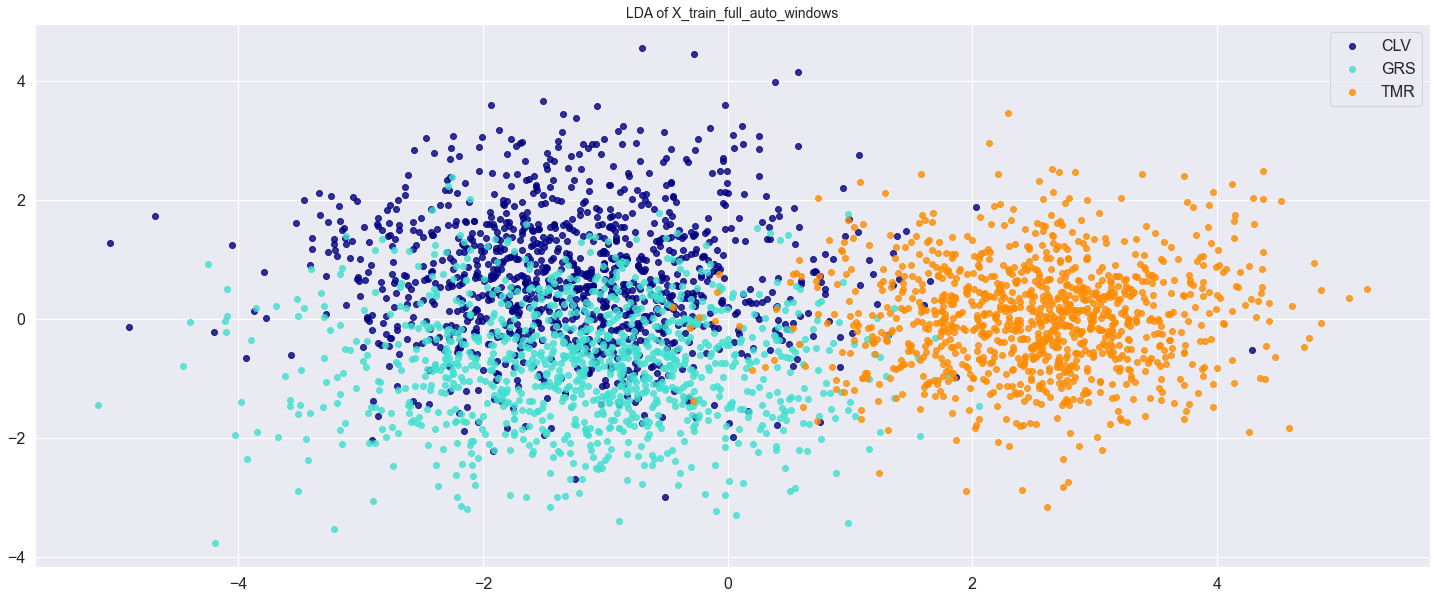

In [191]:
print("columns after window removal:", X_train_full_auto_windows.columns)
selector = SelectFromModel(estimator=RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True)).fit(X_train_full_auto_windows, y)
#selector.estimator_.coef_
print("threshold: ", selector.threshold_)
print("number of selected features: ", selector.get_support().sum())
#print("coefs: ", selector.estimator_.coef_)

top_features = {}
for idx in range(0, len(selector.get_support())):
    if selector.get_support()[idx]:
        #print(features[idx], selector.estimator_.coef_[:,idx])
        sum_coefs = 0
        for coef in selector.estimator_.coef_[:,idx]:
            sum_coefs += np.abs(coef)
        top_features[features[idx]] = sum_coefs
        
#print(top_features)   
#print(sorted(top_features.items(), key=lambda x: x[1], reverse=True)[:70])

for i in sorted(top_features.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(i)
    
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_new = X_train_full_auto_windows[X_train_full_auto_windows.columns[selector.get_support()]]
X_r2 = lda.fit(X_train_new, y).transform(X_train_new)

print(X_r2[:10], "\n", y[:10])

target_names = unique_labels(y)

plt.figure(figsize=(25, 10))
colors = ["navy", "turquoise", "darkorange"]
lw = 2

yn = labelencoder.fit_transform(y)

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[yn == i, 0], X_r2[yn == i, 1], alpha=0.8, color=color, label=target_name)
    
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of X_train_full_auto_windows")

plt.show()

X_train
Accuracy: 0.9660842754367934


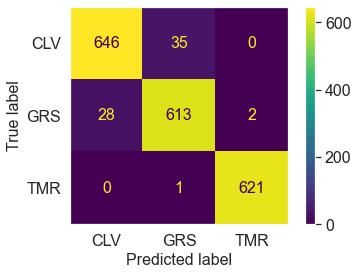


Classification report:
                precision    recall  f1-score   support

         CLV       0.96      0.95      0.95       681
         GRS       0.94      0.95      0.95       643
         TMR       1.00      1.00      1.00       622

    accuracy                           0.97      1946
   macro avg       0.97      0.97      0.97      1946
weighted avg       0.97      0.97      0.97      1946

train60 class distrib:
 CLV    681
GRS    643
TMR    622
Name: Diet, dtype: int64
train60 class distrib:
 CLV    0.349949
GRS    0.330421
TMR    0.319630
Name: Diet, dtype: float64
train60 predicted class distrib:
 CLV    674
GRS    649
TMR    623
dtype: int64
train60 predicted class distrib:
 CLV    0.346351
GRS    0.333505
TMR    0.320144
dtype: float64
X_test
Accuracy: 0.8258859784283513


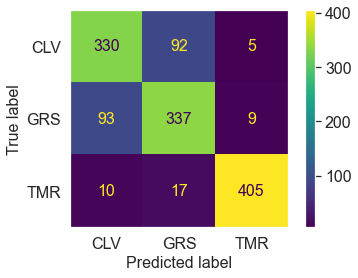


Classification report:
                precision    recall  f1-score   support

         CLV       0.76      0.77      0.77       427
         GRS       0.76      0.77      0.76       439
         TMR       0.97      0.94      0.95       432

    accuracy                           0.83      1298
   macro avg       0.83      0.83      0.83      1298
weighted avg       0.83      0.83      0.83      1298

test40 class distrib:
 CLV    427
GRS    439
TMR    432
Name: Diet, dtype: int64
test40 class distrib:
 CLV    0.328968
GRS    0.338213
TMR    0.332820
Name: Diet, dtype: float64
test40 predicted class distrib:
 CLV    433
GRS    446
TMR    419
dtype: int64
test40 predicted class distrib:
 CLV    0.333590
GRS    0.343606
TMR    0.322804
dtype: float64
['GRS' 'CLV' 'GRS' ... 'CLV' 'GRS' 'GRS']
final test pred class distrib:
 CLV    387
GRS    355
TMR    335
dtype: int64
final test pred class distrib:
 CLV    0.359331
GRS    0.329619
TMR    0.311049
dtype: float64
  Diet      col1      co

In [186]:
# Feature selection, poly2, LDA
clf = Pipeline([
         ('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
         #('classification', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))
        #('feature_selection', SelectKBest(k = 50)),    
        ('fpoly', PolynomialFeatures(degree=2)),
        ('classification', LinearDiscriminantAnalysis())
        ])

clf.fit(X_train, y_train)
print("X_train")
y_pred = clf.predict(X_train)
predict_eval(clf, y_train, y_pred)
printMetrics(y_train, y_pred)
print("train60 class distrib:\n", y_train.value_counts().sort_index(ascending=True))
print("train60 class distrib:\n", y_train.value_counts(normalize=True).sort_index(ascending=True))
print("train60 predicted class distrib:\n", pd.DataFrame(y_pred).value_counts().sort_index(ascending=True))
print("train60 predicted class distrib:\n", pd.DataFrame(y_pred).value_counts(normalize=True).sort_index(ascending=True))

print("X_test")
y_pred = clf.predict(X_test)
predict_eval(clf, y_test, y_pred)
printMetrics(y_test, y_pred)
print("test40 class distrib:\n", y_test.value_counts().sort_index(ascending=True))
print("test40 class distrib:\n", y_test.value_counts(normalize=True).sort_index(ascending=True))
print("test40 predicted class distrib:\n", pd.DataFrame(y_pred).value_counts().sort_index(ascending=True))
print("test40 predicted class distrib:\n", pd.DataFrame(y_pred).value_counts(normalize=True).sort_index(ascending=True))

X_train_full = X
X_test_full = test_df[features]

clf.fit(X_train_full, y)
y_pred_test = clf.predict(X_test_full)
#print(X_test_full_auto_windows)
print(y_pred_test)
print("final test pred class distrib:\n", pd.DataFrame(y_pred_test).value_counts().sort_index(ascending=True) )
print("final test pred class distrib:\n", pd.DataFrame(y_pred_test).value_counts(normalize=True).sort_index(ascending=True))

test_df_pred = pd.concat([pd.DataFrame(y_pred_test, columns=['Diet'], index=X_test_full.index), X_test_full], axis=1)
print(test_df_pred.head(3))

In [187]:
# Predicted class on test set
print("Predictions on the unlabeled test data: \n", y_pred_test)

test_df_pred.to_csv('27042021-diet-test-predictions-selectfrommodel-poly2-LDA.csv', index=False)



Predictions on the unlabeled test data: 
 ['GRS' 'CLV' 'GRS' ... 'CLV' 'GRS' 'GRS']


[[-2.82359969  1.29670523]
 [ 2.75446795 -0.81032179]
 [ 0.32125555 -1.35647485]
 [-0.47619833 -1.88984322]
 [-1.60573871 -1.7500228 ]
 [-2.79798318  1.16014784]
 [-1.66152893  0.40308701]
 [-2.26862004  0.83690479]
 [-3.02395714  2.04239175]
 [ 2.92198056 -1.1071578 ]] 
 1341    CLV
2455    TMR
2413    GRS
2240    GRS
305     GRS
1118    CLV
2586    GRS
2670    CLV
1191    CLV
2121    TMR
Name: Diet, dtype: object


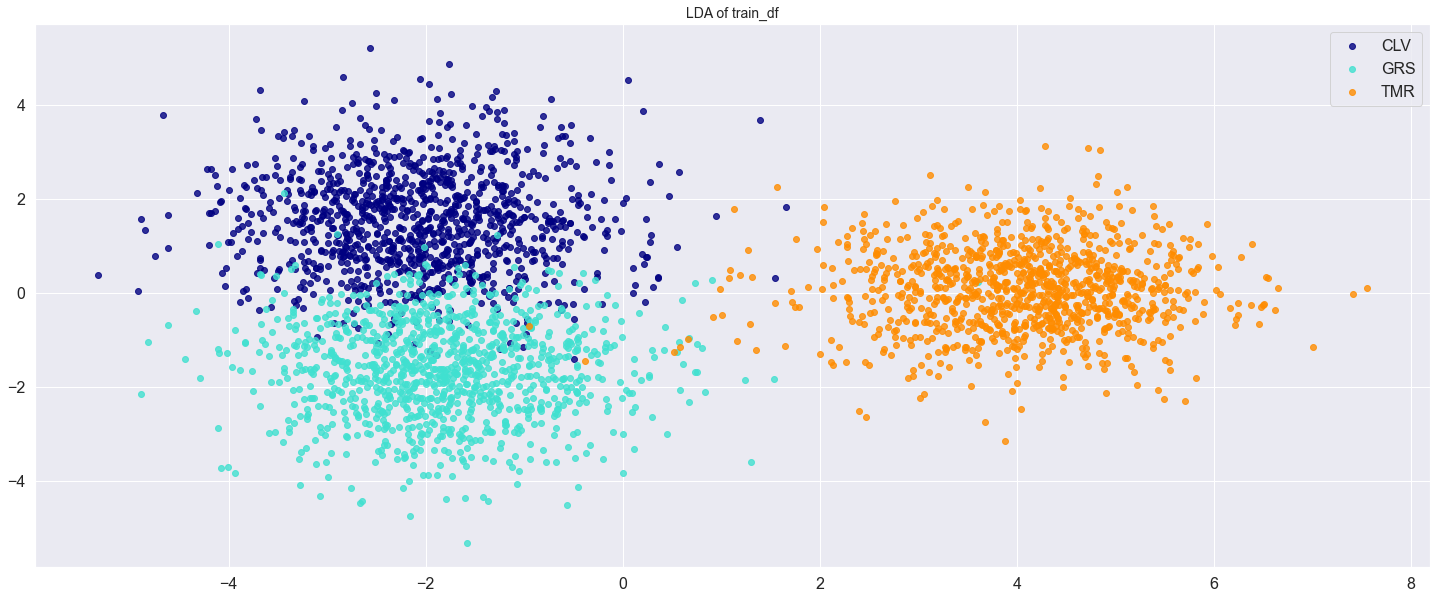

In [192]:
# Visualise the training data according to the 2 LDA components trained above
X_r2 = clf.fit(X, y).transform(X)

print(X_r2[:10], "\n", y[:10])

target_names = unique_labels(y)

plt.figure(figsize=(25, 10))
colors = ["navy", "turquoise", "darkorange"]
lw = 2

labelencoder = LabelEncoder()
yn = labelencoder.fit_transform(y)

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[yn == i, 0], X_r2[yn == i, 1], alpha=0.8, color=color, label=target_name)
    
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of train_df")

plt.show()


[[-1.63078275 -1.08206747]
 [-3.09832734  1.38239017]
 [-3.59918615 -2.32222681]
 [-2.66674138 -1.89284515]
 [-2.16425247 -1.25504602]
 [-3.59792361 -1.20209387]
 [ 0.13686904  0.51144237]
 [-2.35243965 -2.88452245]
 [-3.22495999 -1.07016574]
 [-1.08019194  0.19502748]] 
 1341    CLV
2455    TMR
2413    GRS
2240    GRS
305     GRS
1118    CLV
2586    GRS
2670    CLV
1191    CLV
2121    TMR
Name: Diet, dtype: object


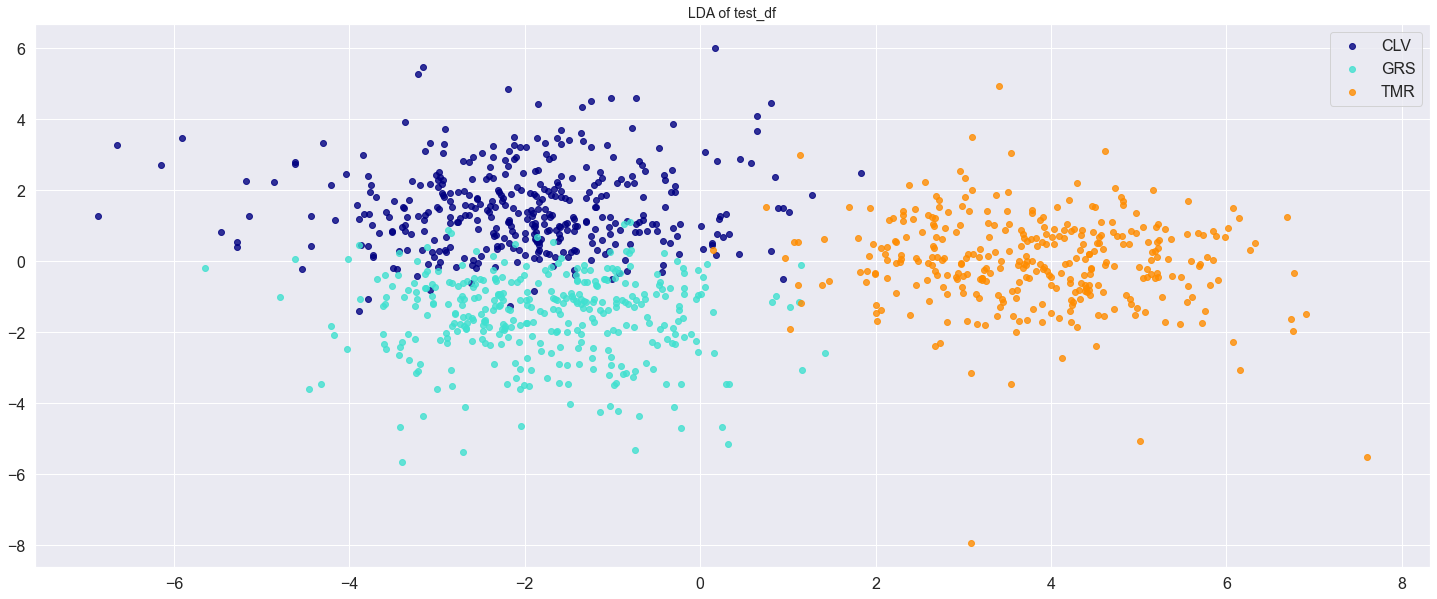

In [193]:
# Visualise the test data according to the 2 LDA components trained above
X_r2 = clf.fit(X, y).transform(X_test_full)

print(X_r2[:10], "\n", y[:10])

target_names = unique_labels(y_pred_test)

plt.figure(figsize=(25, 10))
colors = ["navy", "turquoise", "darkorange"]
lw = 2

labelencoder = LabelEncoder()
yn = labelencoder.fit_transform(y_pred_test)

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[yn == i, 0], X_r2[yn == i, 1], alpha=0.8, color=color, label=target_name)
    
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of test_df")

plt.show()



<ipython-input-194-952a35a698b6>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(25))


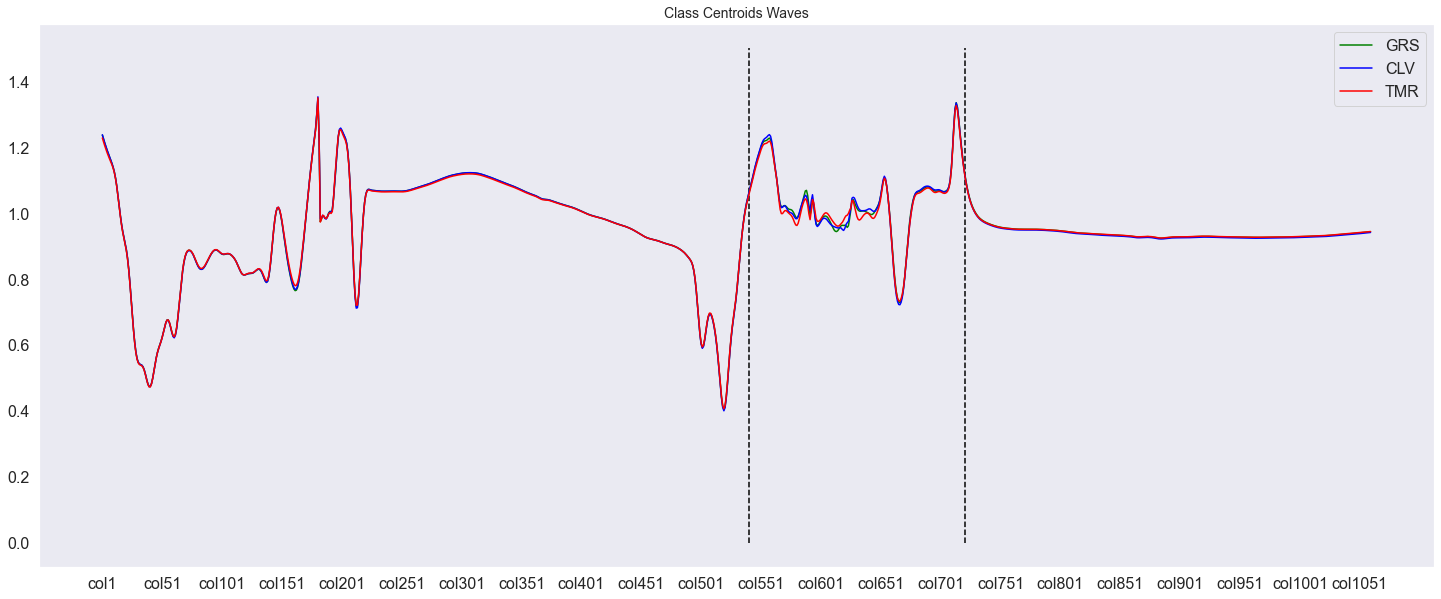

In [194]:
def plotWavesClasses(df, features):
    
    training_GRS = df[df["Diet"] == 'GRS']
    training_CLV = df[df["Diet"] == 'CLV']
    training_TMR = df[df["Diet"] == 'TMR']
    
    plt.figure(figsize=(25, 10))
    
    #plt.plot(df[features].T, color='LightBlue')
    plt.plot(training_GRS[features].mean().T, color='Green', label='GRS')
    plt.plot(training_CLV[features].mean().T, color='Blue', label='CLV')
    plt.plot(training_TMR[features].mean().T, color='Red', label='TMR')
    
    #plt.xticks(rotation=45, ha='right')
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(25))
    plt.vlines(540, ymin=0, ymax=1.5, color='black', linestyle='--')
    plt.vlines(720, ymin=0, ymax=1.5, color='black', linestyle='--')

    plt.title('Class Centroids Waves')
    plt.legend()
    plt.grid()
    

if __name__ == "__main__":
    plotWavesClasses(df = training_df, features = features)

<ipython-input-194-952a35a698b6>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(25))


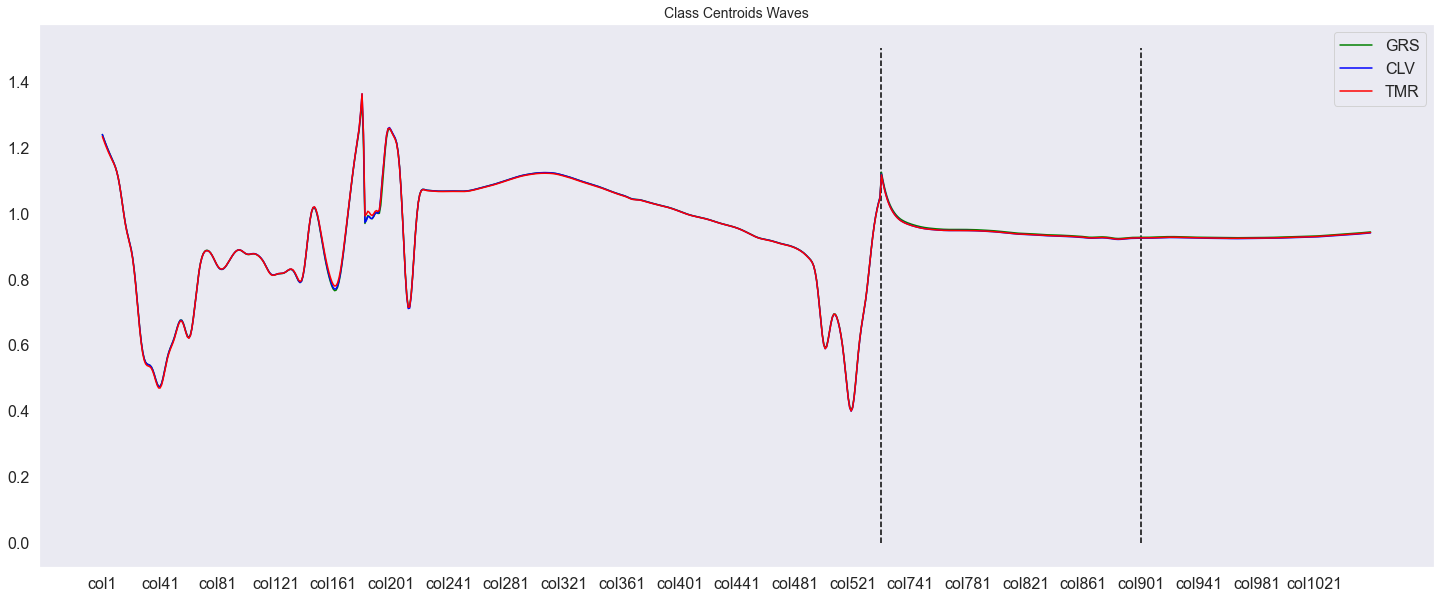

In [195]:
plotWavesClasses(df = test_df_pred, features = test_df_pred.columns)

In [196]:
training_df.shape


(3244, 1061)

In [197]:
target = 'GRS' 
df_target = training_df[training_df['Diet'] == target]
df_target.shape

(1082, 1061)

<ipython-input-198-a78d00cdc849>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))


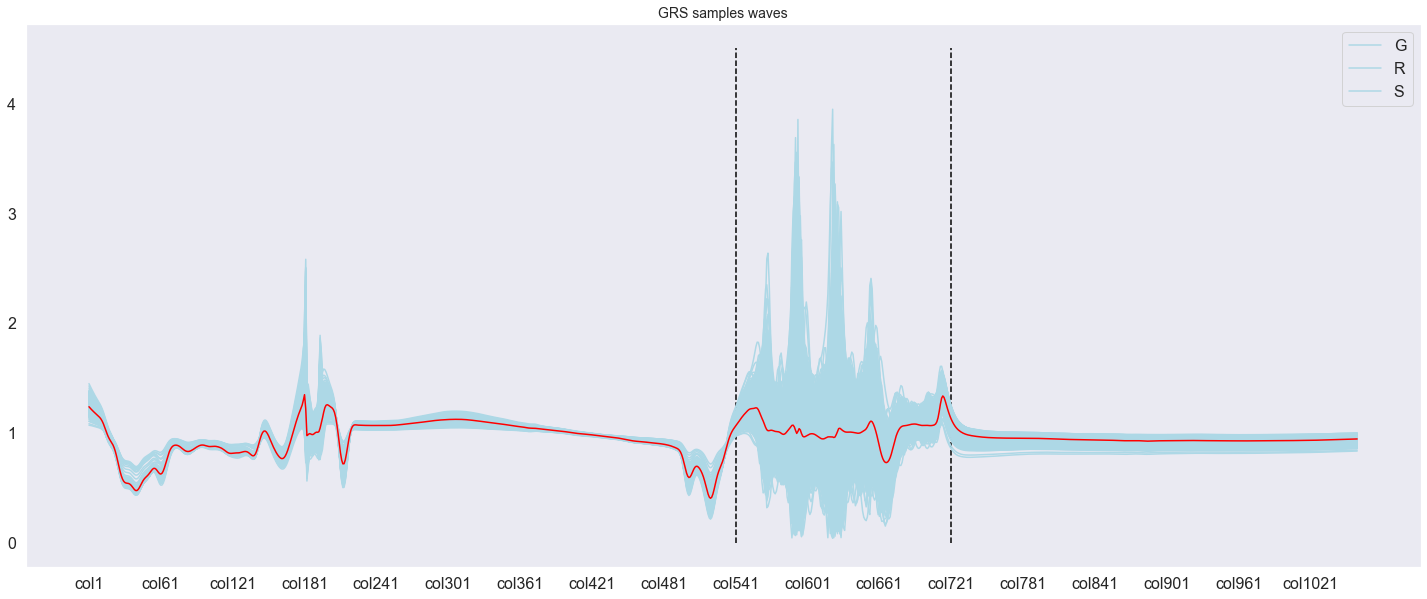

In [198]:
def plotWavesTarget(df, features, target='GRS'):
    
    plt.figure(figsize=(25, 10))
    df_target = df[df['Diet'] == target]
    
    plt.plot(df_target[features].T, color='LightBlue')
    plt.plot(df_target[features].mean().T, color='Red')
    #plt.plot(df_sorted[features].iloc[0:1000].T)
    #plt.plot(df_sorted[features].iloc[0:100].T)
    #plt.plot(df_sorted[features].iloc[[100]].T)
    
    #plt.xticks(rotation=45, ha='right')
    #plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.vlines(540, ymin=0, ymax=4.5, color='black', linestyle='--')
    plt.vlines(720, ymin=0, ymax=4.5, color='black', linestyle='--')
    plt.title(target + ' samples waves')
    plt.legend(target)
    plt.grid()
    

if __name__ == "__main__":
    plotWavesTarget(df = training_df, features = features, target = 'GRS')
    

<ipython-input-198-a78d00cdc849>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))


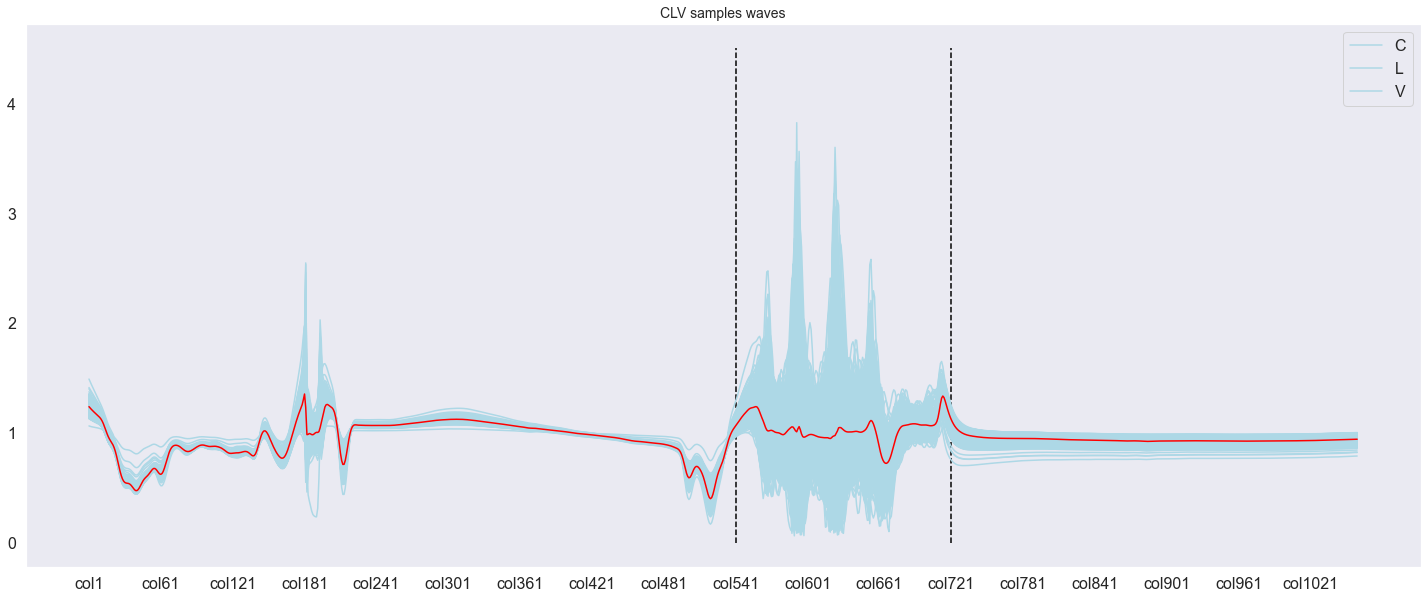

In [199]:
plotWavesTarget(df = training_df, features = features, target = 'CLV')

<ipython-input-198-a78d00cdc849>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))


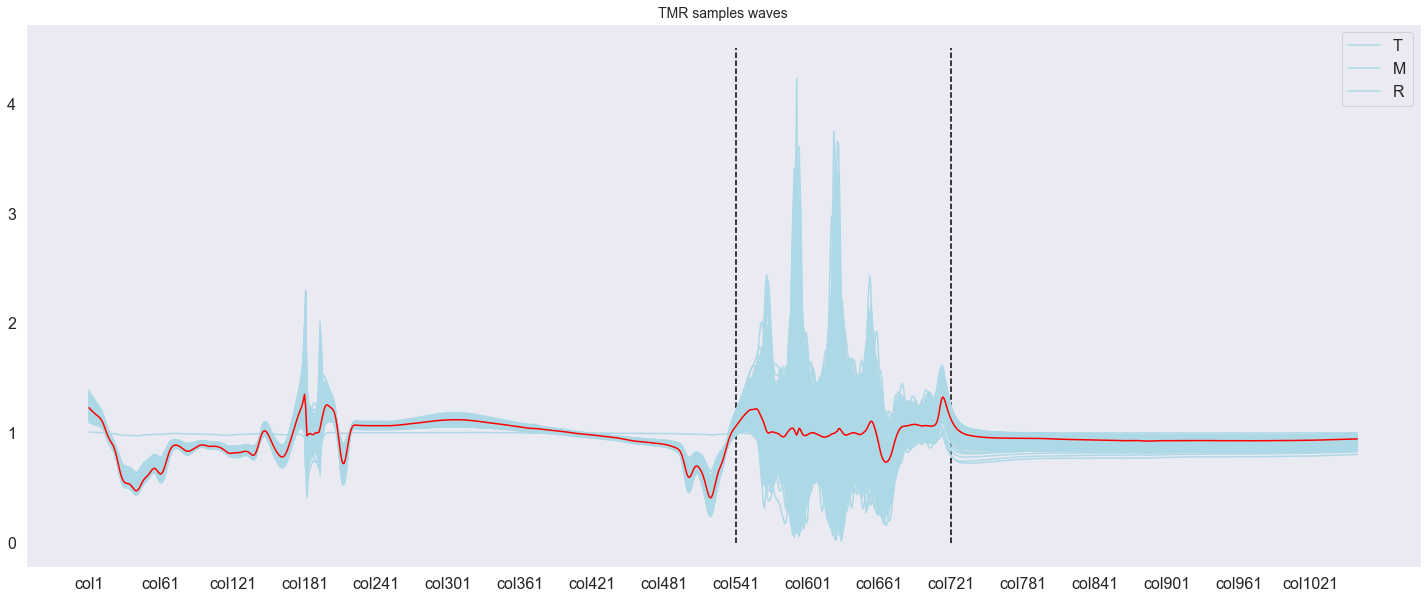

In [200]:
plotWavesTarget(df = training_df, features = features, target = 'TMR')

<ipython-input-201-e6d99ab1e242>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
No handles with labels found to put in legend.


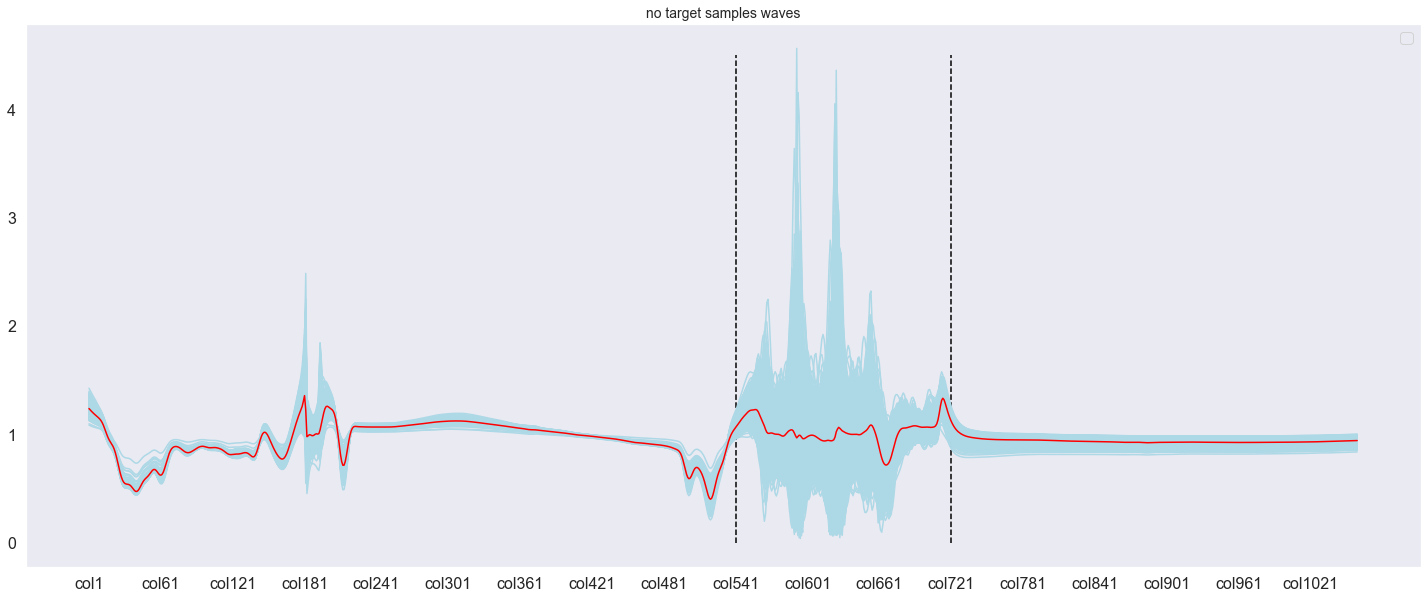

In [201]:
 def plotWavesNoTarget(df, features):

    plt.figure(figsize=(25, 10))
    
    plt.plot(df[features].T, color='LightBlue')
    plt.plot(df[features].mean().T, color='Red')
    #plt.plot(df_sorted[features].iloc[0:1000].T)
    #plt.plot(df_sorted[features].iloc[0:100].T)
    #plt.plot(df_sorted[features].iloc[[100]].T)
    
    #plt.xticks(rotation=45, ha='right')
    #plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.vlines(540, ymin=0, ymax=4.5, color='black', linestyle='--')
    plt.vlines(720, ymin=0, ymax=4.5, color='black', linestyle='--')
    plt.title('no target samples waves')
    plt.legend()
    plt.grid()
    

if __name__ == "__main__":
    plotWavesNoTarget(df = test_df, features = test_df.columns)

In [202]:
test_pred_df = pd.read_csv("predictions_submitted/22042021-Georgiana-diet-wsize90-idx10-selectfrommodel-LDA-test-pred-only-no-outliers.csv")
test_pred_df.shape

(1077, 1)

In [203]:
test_pred_df['Diet'].value_counts()

GRS    364
CLV    361
TMR    352
Name: Diet, dtype: int64

In [204]:
test_pred_df['Diet'].value_counts(normalize=True)

GRS    0.337976
CLV    0.335190
TMR    0.326834
Name: Diet, dtype: float64

In [205]:
test_pred_df = pd.read_csv("predictions_submitted/22042022_Antonio-FCN_NO_WATER_12000_test-pred-only-no-outliers.csv")
test_pred_df.shape

(1077, 1)

In [206]:
test_pred_df['Diet'].value_counts()

CLV    373
TMR    352
GRS    352
Name: Diet, dtype: int64

In [207]:
test_pred_df['Diet'].value_counts(normalize=True)

CLV    0.346332
TMR    0.326834
GRS    0.326834
Name: Diet, dtype: float64

In [208]:
test_pred_df = pd.read_csv("predictions_submitted/22042022-Bhaskar-RFECV-ridge_test-pred-only-no-outliers.csv")
test_pred_df.shape

(1077, 1)

In [209]:
test_pred_df['Diet'].value_counts().sort_index(ascending=True)

CLV    352
GRS    360
TMR    365
Name: Diet, dtype: int64

In [210]:
test_pred_df['Diet'].value_counts(normalize=True).sort_index(ascending=True)

CLV    0.326834
GRS    0.334262
TMR    0.338904
Name: Diet, dtype: float64

In [211]:
test_pred_df = pd.read_csv("predictions_submitted/22042022-Thach_Bespoke_prediction_test-pred-only_no-outliers.csv")
test_pred_df.shape

(1077, 1)

In [212]:
test_pred_df['Diet'].value_counts()

CLV    372
GRS    366
TMR    339
Name: Diet, dtype: int64

In [213]:
test_pred_df['Diet'].value_counts(normalize=True)

CLV    0.345404
GRS    0.339833
TMR    0.314763
Name: Diet, dtype: float64